In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy.random import Generator, PCG64
import math
from random import sample
import random
rng = Generator(PCG64())
import copy
from tqdm import tqdm
import csv
from scipy.optimize import curve_fit
#1000*rng.uniform(-1, 1, (2,6))


Generation of candidates and voters

In [2]:
#Generation of candidates

def CandGen(amount = 10, distr = 'normal', bounds = 1):
  if distr == 'normal':
    candidates = bounds*rng.standard_normal((2, amount))
  elif distr == 'uniform':
    candidates = rng.uniform(-1*bounds, bounds, (2, amount))
  elif distr == 'radial':
    phi = rng.uniform(0, 2*math.pi, (1, amount))
    #print(phi)
    ro = bounds*math.sqrt(math.pi)*rng.triangular(0, 1/math.sqrt(math.pi), 1/math.sqrt(math.pi), (1, amount))
    #print(ro)
    candidates = np.array([ro[0]*np.cos(phi[0]), ro[0]*np.sin(phi[0])])
  elif distr == 'radial2':
    phi = rng.uniform(0, 2*math.pi, (1, amount))
    #print(phi)
    ro = rng.uniform(0, bounds*bounds, (1, amount))
    #print(ro)
    candidates = np.array([np.sqrt(ro[0])*np.cos(phi[0]), np.sqrt(ro[0])*np.sin(phi[0])])
  
  return candidates

#Generation of voters

def VotGen(amount = 300, distr = 'normal', bounds = 1):
  if distr == 'normal':
    voters = bounds*rng.standard_normal((2, amount))
  elif distr == 'uniform':
    voters = rng.uniform(-1*bounds, bounds, (2, amount))
  elif distr == 'radial':
    phi = rng.uniform(0, 2*math.pi, (1, amount))
    #print(phi)
    ro = rng.uniform(0, bounds*bounds, (1, amount))
    #print(ro)
    voters = np.array([np.sqrt(ro[0])*np.cos(phi[0]), np.sqrt(ro[0])*np.sin(phi[0])])
  return voters

#mean distances between candidates function

def meanDist(C):
  Camount = len(C[0])
  Candists = np.ones(Camount)
  Candists = Candists*999999
  closestC = np.zeros(Camount)
  for i in range(Camount):
    for j in range(Camount):
      d = np.sqrt((C[0][i] - C[0][j])**2 + (C[1][i] - C[1][j])**2)
      if d < Candists[i] and i != j:
        Candists[i] = d
        closestC[i] = j
  mD = np.mean(Candists)
  return mD

#STV without figure

def STV_light(Votes, Vamount, Camount, ComAmount, C, V, d1):
  top = []
  flag = 0
  k = ComAmount
  #CamountSTV = Camount
  deleted = []
  PS_Start = np.zeros(Camount)
  for e in Votes:
    PS_Start[e[0]] += 1

  BS = np.zeros(Camount)
  for i in range(Camount):
    for e in Votes:
      #print(np.where(e == i)[0][0])
      BS[i] = BS[i] + (np.where(e == i)[0][0])

  while(len(top) < k):
    Votes = np.array(Votes)
    #print(Votes[0])
    n = len(Votes)
    #print("size:", n)
    q = n//(k+1) + 1
    #print("q:", q)
    PS = np.zeros(Camount)
    if flag == 1:
      PS[deleted] = None
    for e in Votes:
      PS[e[0]] += 1
    c = np.nanargmax(PS)
    #print("c:", c, "PS:", PS[c])
    if PS[c] >= q:
      top.append(c)
      ind = np.where(Votes == c)
      need = np.where(ind[1] == 0)
      for_remove = ind[0][need]
      #print(for_remove)
      if len(for_remove) > q:
        sdvig = np.random.randint(0, len(for_remove) - q)
        rem = for_remove[(0 + sdvig) : (q + sdvig)]
      else:
        rem = for_remove
      
      #print(rem)
      Votes = np.delete(Votes, rem, 0)

      ind = np.where(Votes == c)
      Votes1 = []
      for i in range(len(Votes)):
        Votes1.append(np.delete(Votes[i], ind[1][i]))
      Votes = Votes1
    else:
      c = np.nanargmin(PS)
      #print("c else:", c)
      ind = np.where(Votes == c)
      #print(ind)
      Votes1 = []
      for i in range(len(Votes)):
        Votes1.append(np.delete(Votes[i], ind[1][i]))
      Votes = Votes1
    #CamountSTV -= 1
    flag = 1
    deleted.append(c)
  Committee = np.zeros((2, ComAmount))
  PSmin = Vamount*Camount
  BSmax = 0
  for i in range(ComAmount):
    Committee[0][i] = C[0][top[i]]
    Committee[1][i] = C[1][top[i]]
    if PSmin > PS_Start[top[i]]:
      PSmin = PS_Start[top[i]]
    if BSmax < BS[top[i]]:
      BSmax = BS[top[i]]
  S = Score(Committee, Vamount, ComAmount, d1, V)
  #print("Score of STV rule is ", S)
  #print("median Score of STV rule is ", medianScore(Committee))
  #print("min PS is", PSmin)
  #print("max BS is", BSmax)
  return PSmin, BSmax, S

#SNTV without figure

def SNTV_light(Votes, Vamount, Camount, ComAmount, C, V, d1):
  PS = np.zeros(Camount)
  k = ComAmount
  for e in Votes:
    PS[e[0]] += 1
  BS = np.zeros(Camount)
  for i in range(Camount):
    for e in Votes:
      BS[i] = BS[i] + (np.where(e == i)[0][0])
  Committee = np.zeros((2, ComAmount))
  top = np.argsort(PS, )
  PSmin = Vamount*Camount
  BSmax = 0
  for i in range(ComAmount):
    Committee[0][i] = C[0][top[Camount - i - 1]]
    Committee[1][i] = C[1][top[Camount - i - 1]]
    if PSmin > PS[top[Camount - i - 1]]:
      PSmin = PS[top[Camount - i - 1]]
    if BSmax < BS[top[Camount - i - 1]]:
      BSmax = BS[top[Camount - i - 1]]
  S = Score(Committee, Vamount, ComAmount, d1, V)
  #print("Score of SNTV rule is ", S)
  #print("median Score of SNTV rule is ", medianScore(Committee))
  return PSmin, BSmax, S

#Borda rule without figure

def Borda_light(Votes, Vamount, Camount, ComAmount, C, V, d1):
  PS = np.zeros(Camount)
  k = ComAmount
  for e in Votes:
    PS[e[0]] += 1
  BS = np.zeros(Camount)
  for i in range(Camount):
    for e in Votes:
      #print(np.where(e == i)[0][0])
      BS[i] = BS[i] + (np.where(e == i)[0][0])
  top = np.argsort(BS)
  Committee = np.zeros((2, ComAmount))
  PSmin = Vamount*Camount
  BSmax = 0
  for i in range(ComAmount):
    Committee[0][i] = C[0][top[i]]
    Committee[1][i] = C[1][top[i]]
    if PSmin > PS[top[i]]:
      PSmin = PS[top[i]]
    if BSmax < BS[top[i]]:
      BSmax = BS[top[i]]
  S = Score(Committee, Vamount, ComAmount, d1, V)
  #print("Score of k-Borda rule is ", S)
  #print("median Score of k-Borda rule is ", medianScore(Committee))
  return PSmin, BSmax, S

#STV rule

def STV(Votes, Vamount, Camount, ComAmount, C, V, d1):
  top = []
  flag = 0
  k = ComAmount
  #CamountSTV = Camount
  deleted = []
  while(len(top) < k):
    Votes = np.array(Votes)
    #print(Votes[0])
    n = len(Votes)
    #print("size:", n)
    q = n//(k+1) + 1
    #print("q:", q)
    PS = np.zeros(Camount)
    if flag == 1:
      PS[deleted] = None
    for e in Votes:
      PS[e[0]] += 1
    c = np.nanargmax(PS)
    #print("c:", c, "PS:", PS[c])
    if PS[c] >= q:
      top.append(c)
      ind = np.where(Votes == c)
      need = np.where(ind[1] == 0)
      for_remove = ind[0][need]
      #print(for_remove)
      if len(for_remove) > q:
        sdvig = np.random.randint(0, len(for_remove) - q)
        rem = for_remove[(0 + sdvig) : (q + sdvig)]
      else:
        rem = for_remove
      
      #print(rem)
      Votes = np.delete(Votes, rem, 0)

      ind = np.where(Votes == c)
      Votes1 = []
      for i in range(len(Votes)):
        Votes1.append(np.delete(Votes[i], ind[1][i]))
      Votes = Votes1
    else:
      c = np.nanargmin(PS)
      #print("c else:", c)
      ind = np.where(Votes == c)
      #print(ind)
      Votes1 = []
      for i in range(len(Votes)):
        Votes1.append(np.delete(Votes[i], ind[1][i]))
      Votes = Votes1
    #CamountSTV -= 1
    flag = 1
    deleted.append(c)
  Committee = np.zeros((2, ComAmount))

  for i in range(ComAmount):
    Committee[0][i] = C[0][top[i]]
    Committee[1][i] = C[1][top[i]]

  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  ax.scatter(Committee[0], Committee[1], s = 70, c = '#01b700', alpha = 0.7)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('comSTV.png', dpi=100)
  Sc = Score(Committee, Vamount, ComAmount, d1, V)
  Sa = ScoreArr(Committee, Vamount, ComAmount, d1, V)
  Sa = np.array(Sa)
  print("Score of STV rule is ", Sc)
  print("median Score of STV rule is ", medianScore(Committee, Vamount, ComAmount, d1, V))

  return Committee, Sc, Sa

#Random committee

def randCom(listCan, Vamount, Camount, ComAmount, C, V, d1, volume = 1000):
  S = 0
  k = ComAmount
  #volume = round(200000/len(listCan))
  #volume = math.comb(len(listCan), k)
  if k == len(listCan):
    MBCom = listCan
    Committee = np.zeros((2, ComAmount))
    for i in range(ComAmount):
      Committee[0][i] = C[0][MBCom[i]]
      Committee[1][i] = C[1][MBCom[i]]
    St = Score(Committee, Vamount, ComAmount, d1, V)
    S = St
    print(S)
    OptX = copy.deepcopy(MBCom)
    OptCom = copy.deepcopy(Committee)

    fig, ax = plt.subplots()
    #figure(figsize=(16, 12), dpi=80)
    ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
    ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
    ax.scatter(OptCom[0], OptCom[1], s = 70, c = '#01b700', alpha = 0.7)
    plt.show()
    fig.set_size_inches(10, 10)
    fig.savefig('comRAND.png', dpi=100)
    print("Score of Random is ", S)
    print("median Score of Random is ", medianScore(OptCom, Vamount, ComAmount, d1, V))
    return OptCom, OptX



  for j in tqdm(range(volume)):

    MBCom = sample(list(listCan), k)
    Committee = np.zeros((2, ComAmount))
    for i in range(ComAmount):
      Committee[0][i] = C[0][MBCom[i]]
      Committee[1][i] = C[1][MBCom[i]]
    St = Score(Committee, Vamount, ComAmount, d1, V)
    if St > S:
      S = St
      print(S)
      OptX = copy.deepcopy(MBCom)
      OptCom = copy.deepcopy(Committee)

  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  ax.scatter(OptCom[0], OptCom[1], s = 70, c = '#01b700', alpha = 0.7)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('comRAND.png', dpi=100)
  print("Score of Random is ", Score(OptCom, Vamount, ComAmount, d1, V))
  print("median Score of Random is ", medianScore(OptCom, Vamount, ComAmount, d1, V))
  return OptCom, OptX

#Brut Force committee

def brutForce(ComAmount, C, V, d1, Vamount = 100, Camount = 12):
  S = 0
  k = ComAmount
  #volume = round(200000/len(listCan))
  #volume = math.comb(Camount, k)
  volume = int(math.pow(2, Camount))
  for j in tqdm(range(volume)):
    decision = ToBin(j, Camount)
    if np.count_nonzero(decision) == k:
      MBCom = np.nonzero(decision)[0]
      Committee = np.zeros((2, ComAmount))
      for i in range(ComAmount):
        Committee[0][i] = C[0][MBCom[i]]
        Committee[1][i] = C[1][MBCom[i]]
      St = Score(Committee, Vamount, ComAmount, d1, V)
      if St > S:
        S = St
        #print(S)
        OptX = copy.deepcopy(MBCom)
        OptCom = copy.deepcopy(Committee)

  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  ax.scatter(OptCom[0], OptCom[1], s = 70, c = '#01b700', alpha = 0.7)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('BF.png', dpi=100)
  print("Score of Random is ", Score(OptCom, Vamount, ComAmount, d1, V))
  print("median Score of Random is ", medianScore(OptCom, Vamount, ComAmount, d1, V))
  return OptCom, OptX, Score(OptCom, Vamount, ComAmount, d1, V)

#Random committee by median

def randComMed(listCan, Vamount, Camount, ComAmount, C, V, d1):
  S = 0
  k = ComAmount
  #volume = round(200000/len(listCan))
  volume = math.comb(len(listCan), k)
  if volume > 1000:
    volume = 1000
  elif volume < 100:
    volume = 100
  for j in tqdm(range(volume)):

    MBCom = sample(list(listCan), k)
    Committee = np.zeros((2, ComAmount))
    for i in range(ComAmount):
      Committee[0][i] = C[0][MBCom[i]]
      Committee[1][i] = C[1][MBCom[i]]
    St = medianScore(Committee, Vamount, ComAmount, d1, V)
    if St > S:
      S = St
      print(S)
      OptX = copy.deepcopy(MBCom)
      OptCom = copy.deepcopy(Committee)

  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  ax.scatter(OptCom[0], OptCom[1], s = 70, c = '#01b700', alpha = 0.7)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('comRAND.png', dpi=100)
  print("Score of Random is ", Score(OptCom, Vamount, ComAmount, d1, V))
  print("median Score of Random is ", medianScore(OptCom, Vamount, ComAmount, d1, V))
  print("k is still", len(OptX))
  return OptCom, OptX

#prune the search space funtion

def pruneSS(Votes, Vamount, Camount, ComAmount, C, V, d1):
  CN = copy.deepcopy(C)
  Cand = np.arange(Camount)
  k = ComAmount
#do PS array
  PS = np.zeros(Camount)
  for e in Votes:
    PS[e[0]] += 1
  #PS = np.array(PS)
  mD = meanDist(C)
#find Candidates to delete
  remPS = np.where(PS == 0)[0]
  if len(Cand) - len(remPS) < k:
    if len(Cand) - k > 0:
      sliceObj = slice(0, len(Cand) - k)
      remPS = remPS[sliceObj]
    else:
      remPS = np.array([])

  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd', label = 'Voters')
  ax.scatter(C[0], C[1], s = 50, c = '#a7a7a7', alpha = 0.7, label = 'removed by PS = 0')

  print("Removed1", len(remPS))
#delete PS=0 candidates from Cand
  Cand = np.delete(Cand, remPS)
  Committee = np.zeros((2, len(Cand)))
  for i in range(len(Cand)):
    Committee[0][i] = C[0][Cand[i]]
    Committee[1][i] = C[1][Cand[i]]


  ax.scatter(Committee[0], Committee[1], s = 70, c = '#c00007', alpha = 0.7, label = 'removed by BS')
#delete from Votes
  for r in remPS:
    ind = np.where(Votes == r)
    Votes1 = []
    for i in range(len(Votes)):
      Votes1.append(np.delete(Votes[i], ind[1][i]))
    Votes = Votes1
#do BS array (full)
  BS = np.zeros(Camount)

  for i in range(Camount):
    for e in Votes:
      if len(np.where(e == i)[0]) > 0:
        BS[i] = BS[i] + (np.where(e == i)[0][0])
      else:
        BS[i] = Vamount*Camount*2
  #BS = np.array(BS)
  Coef1 = 0.7
  Coef2 = 0.7
  #Coef3 = Camount/(math.pi*b**2)*mD**2
  #print(Coef3)
  Drop = Vamount*Camount*Coef1
#find candidates to delete
  
  #print("Removed2", len(remBS))
#delete those from Votes
  #VotesTemp = Votes
  #for r in remBS:
  #  ind = np.where(Votes == r)
  #  if len(ind[1]) > 0:
  #    Votes1 = []
  #    for i in range(len(Votes)):
  #      Votes1.append(np.delete(Votes[i], ind[1][i]))
  #    VotesTemp = copy.deepcopy(Votes1)
  #  else:
  #    VotesTemp = Votes
#delete from BS array candidates with PS=0
  BS = np.delete(BS, remPS)
  remBS = np.where(BS > Drop)[0]
  if len(Cand) - len(remBS) < k:
    if len(Cand) - k > 0:
      sliceObj = slice(0, len(Cand) - k)
      remBS = remBS[sliceObj]
    else:
      remBS = np.array([])
  #else:
  #  Votes = VotesTemp

#delete big-BS candidates from Cand
  #remBS = np.where(BS > Drop)[0]
  print("Removed2.1", len(remBS))

  Cand = np.delete(Cand, remBS)
  Committee = np.zeros((2, len(Cand)))
  for i in range(len(Cand)):
    Committee[0][i] = C[0][Cand[i]]
    Committee[1][i] = C[1][Cand[i]]


  ax.scatter(Committee[0], Committee[1], s = 70, c = '#d7d500', alpha = 0.7, label = 'removed by closeness')
  remD = []

  print("Mean Dist is", mD)
  PS = np.zeros(Camount)
  for e in Votes:
    PS[e[0]] += 1

  for i in range(len(Cand)):
    maybe = []
    for c in Cand:
      d = np.sqrt((C[0][Cand[i]] - C[0][c])**2 + (C[1][Cand[i]] - C[1][c])**2)
      if d < Coef2*mD and c != Cand[i]:
        #print("d", d)
        maybe.append(c)
    for m in maybe:
      if PS[m] > PS[Cand[i]]:
        #print("ok")
        remD.append(i)
        break
  print("Removed3", len(remD))
#delete from Votes and Cand
  if len(Cand) - len(remD) < k:
    if len(Cand) - k > 0:
      sliceObj = slice(0, len(Cand) - k)
      remD = remD[sliceObj]
    else:
      remD = np.array([])
  print("Removed3.1", len(remD))
  if len(remD) > 0:
    remD = np.array(remD)
    Cand = np.delete(Cand, remD)
  print("remaining cands", len(Cand))
  print(k)
  Committee = np.zeros((2, len(Cand)))

  for i in range(len(Cand)):
    Committee[0][i] = C[0][Cand[i]]
    Committee[1][i] = C[1][Cand[i]]


  ax.scatter(Committee[0], Committee[1], s = 70, c = '#07dd07', alpha = 0.8, label = 'the rest')
  ax.legend(fontsize=15, loc ='best')
  #ax.legend()
  
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('CandPruned.png', dpi=100)
  return Cand

#decision array into committee

def ComDec(C, ComAmount, decision):
  Com = np.zeros((2, ComAmount))
  j = 0
  for i in range(len(decision)):
    if decision[i] == 1:
      Com[0][j] = C[0][i]
      Com[1][j] = C[1][i]
      j += 1
  return Com
      
#neighbouring function

def neighbouring(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, Allowed, closeness = 2):
  if np.count_nonzero(Allowed) == ComAmount:
    print("fulled!")
    return Committee, decision
  
  mD = meanDist(C)
  Sbest = Score(Committee, Vamount, ComAmount, d1, V)
  deccurrent = copy.deepcopy(decision)
  decBest = copy.deepcopy(decision)
  #ComTry = copy.deepcopy(Committee)
  ComBest = copy.deepcopy(Committee)
  Camount = len(decision)
  for i in range(Camount):
    if Sbest == 1:
      break
    if decBest[i] == 1:
      #neighs = []
      c = i
      for j in range(Camount):
        if Allowed[j] == 1:
          if np.sqrt((C[0][i] - C[0][j])**2 + (C[1][i] - C[1][j])**2) < closeness*mD:
            if decBest[j] == 0:
              deccurrent[j] = 1
              deccurrent[c] = 0
              ComTry = ComDec(C, ComAmount, deccurrent)
              Scurrent = Score(ComTry, Vamount, ComAmount, d1, V)
              if Scurrent > Sbest:
                decBest = copy.deepcopy(deccurrent)
                ComBest = copy.deepcopy(ComTry)
                Sbest = Scurrent
                print(c,"to",j)
                c = j
                print("Score changed to", Sbest)  
              else:
                deccurrent[j] = 0
                deccurrent[c] = 1
  return ComBest, decBest

#another neighbouring function

def neighbouring2(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, Allowed, closeness = 2):
  if np.count_nonzero(Allowed) == ComAmount:
    print("fulled!")
    return Committee, decision
  mD = meanDist(C)
  Sbest = Score(Committee, Vamount, ComAmount, d1, V)
  deccurrent = copy.deepcopy(decision)
  decBest = copy.deepcopy(decision)
  #ComTry = copy.deepcopy(Committee)
  ComBest = copy.deepcopy(Committee)
  changed = 0
  Camount = len(decision)
  for i in range(Camount):
    if Sbest == 1:
      break
    if decBest[i] == 1:
      #neighs = []
      if changed == 1:
        f = c
      else:
        f = i
        c = i
      for j in range(Camount):
        if Allowed[j] == 1:
          if np.sqrt((C[0][f] - C[0][j])**2 + (C[1][f] - C[1][j])**2) < closeness*mD:
            if decBest[j] == 0:
              deccurrent[j] = 1
              deccurrent[c] = 0
              ComTry = ComDec(C, ComAmount, deccurrent)
              Scurrent = Score(ComTry, Vamount, ComAmount, d1, V)
              if Scurrent > Sbest:
                #if Allowed[j] == 0:
                  #print("pruned good)")
                decBest = copy.deepcopy(deccurrent)
                ComBest = copy.deepcopy(ComTry)
                Sbest = Scurrent
                print(c,"to",j)
                c = j
                print("Score changed to", Sbest)  
              else:
                deccurrent[j] = 0
                deccurrent[c] = 1
  return ComBest, decBest


#Discrette optimisation

def Opt(Votes, Vamount, Camount, ComAmount, C, V, d1):
  
  Cand = pruneSS(Votes, Vamount, Camount, ComAmount, C, V, d1)
  Allowed = np.zeros(Camount)
  for c in Cand:
    Allowed[c] = 1
  
  Committee, OptX = randCom(Cand, Vamount, Camount, ComAmount, C, V, d1, volume = 500)
  decision = np.zeros(Camount)
  for c in OptX:
    decision[c] = 1
  Committee, decision = neighbouring(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, Allowed, 4)
  print("zero done")
  Committee, decision = neighbouring(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, Allowed, 4)
  print("first done")
  Committee, decision = neighbouring2(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, Allowed, 6)
  print("second done")
  #A = np.ones(Camount)
  Committee, decision = neighbouring(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, Allowed, 2)
  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  ax.scatter(Committee[0], Committee[1], s = 70, c = '#01b700', alpha = 0.7)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('comOpt.png', dpi=100)
  Sc = Score(Committee, Vamount, ComAmount, d1, V)
  Sa = ScoreArr(Committee, Vamount, ComAmount, d1, V)
  Sa = np.array(Sa)
  print("Score of Optimization is ", Sc)
  print("median Score of optimization is ", medianScore(Committee, Vamount, ComAmount, d1, V))
  return Committee, Sc, Sa

def OptSNTV_cut(Votes, Vamount, Camount, ComAmount, C, V, d1):
  
  Cand = pruneSS(Votes, Vamount, Camount, ComAmount, C, V, d1)
  Allowed = np.zeros(Camount)
  for c in Cand:
    Allowed[c] = 1
  rem = []
  for i in range(Camount):
    if Allowed[i] == 0:
      rem.append(i)
  rem = np.array(rem)
  Votes = np.array(Votes)
  print(len(rem))
  for r in rem:
    #print("V", Votes[0:10])
    ind = np.where(Votes == r)
    #print("i",ind)
    if len(ind[1]) > 0:
      Votes1 = []
      for i in range(len(Votes)):
        Votes1.append(np.delete(Votes[i], ind[1][i]))
      Votes = copy.deepcopy(Votes1)
      #print("rw")

  PS = np.zeros(Camount)

  for e in Votes:
    PS[e[0]] += 1

  Committee = np.zeros((2, ComAmount))
  top = np.argsort(PS, )
  OptX = []
  for i in range(ComAmount):
    OptX.append(top[Camount - i - 1])
    Committee[0][i] = C[0][OptX[i]]
    Committee[1][i] = C[1][OptX[i]]
  #Committee, OptX = randCom(Cand, Vamount, Camount, ComAmount, C, V, d1, volume = 500)


  decision = np.zeros(Camount)
  for c in OptX:
    decision[c] = 1
  Committee, decision = neighbouring(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, Allowed, 4)
  print("zero done")
  Committee, decision = neighbouring(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, Allowed, 4)
  print("first done")
  Committee, decision = neighbouring2(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, Allowed, 6)
  print("second done")
  #A = np.ones(Camount)
  #Committee, decision = neighbouring(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, Allowed, 2)
  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  ax.scatter(Committee[0], Committee[1], s = 70, c = '#01b700', alpha = 0.7)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('comOptSNTV1.png', dpi=100)
  Sc = Score(Committee, Vamount, ComAmount, d1, V)
  Sa = ScoreArr(Committee, Vamount, ComAmount, d1, V)
  Sa = np.array(Sa)
  print("Score of SNTV-opt (prunned) rule is ", Sc)
  print("median Score of SNTV-opt (prunned) rule is ", medianScore(Committee, Vamount, ComAmount, d1, V))
  return Committee, Sc, Sa

def OptSNTV(Votes, Vamount, Camount, ComAmount, C, V, d1):
  A = np.ones(Camount)
  PS = np.zeros(Camount)

  for e in Votes:
    PS[e[0]] += 1

  Committee = np.zeros((2, ComAmount))
  top = np.argsort(PS, )
  OptX = []
  for i in range(ComAmount):
    OptX.append(top[Camount - i - 1])
    Committee[0][i] = C[0][OptX[i]]
    Committee[1][i] = C[1][OptX[i]]
  #Committee, OptX = randCom(Cand, Vamount, Camount, ComAmount, C, V, d1, volume = 500)


  decision = np.zeros(Camount)
  for c in OptX:
    decision[c] = 1
  Committee, decision = neighbouring(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, A, 4)
  print("zero done")
  Committee, decision = neighbouring(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, A, 4)
  print("first done")
  Committee, decision = neighbouring2(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, A, 6)
  print("second done")
  #Committee, decision = neighbouring(Votes, Vamount, ComAmount, C, V, d1, Committee, decision, A, 2)
  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  ax.scatter(Committee[0], Committee[1], s = 70, c = '#01b700', alpha = 0.7)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('comOptSNTV2.png', dpi=100)
  Sc = Score(Committee, Vamount, ComAmount, d1, V)
  Sa = ScoreArr(Committee, Vamount, ComAmount, d1, V)
  Sa = np.array(Sa)
  print("Score of SNTV-opt rule is ", Sc)
  print("median Score of SNTV-opt rule is ", medianScore(Committee, Vamount, ComAmount, d1, V))
  return Committee, Sc, Sa

#number into binary form function

def ToBin(num, len):
  ar = np.zeros(len)
  c = num
  i = len - 1
  while c > 0:
    ar[i] = c % 2
    c = c//2
    i -= 1
  return ar

#SNTV rule

def Plurality_Score(Votes, Vamount, Camount, ComAmount, C, V, d1):
  k = ComAmount
  PS = np.zeros(Camount)
  for j in range(Camount):
    for e in Votes:
      if e[0] == j:
        PS[j] = PS[j] + 1

  Committee = np.zeros((2, ComAmount))
  top = np.argsort(PS, )

  for i in range(ComAmount):
    Committee[0][i] = C[0][top[Camount - i - 1]]
    Committee[1][i] = C[1][top[Camount - i - 1]]

  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  ax.scatter(Committee[0], Committee[1], s = 70, c = '#01b700', alpha = 0.7)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('comSNTV.png', dpi=100)
  Sc = Score(Committee, Vamount, ComAmount, d1, V)
  Sa = ScoreArr(Committee, Vamount, ComAmount, d1, V)
  Sa = np.array(Sa)
  print("Score of SNTV rule is ", Sc)
  print("median Score of SNTV rule is ", medianScore(Committee, Vamount, ComAmount, d1, V))
  return Committee, Sc, Sa

#k-approval rule

def Approval_Score(Votes, Vamount, Camount, ComAmount, C, V, d1):
  k = ComAmount
  AS = np.zeros(Camount)
  for e in Votes:
    for i in range(ComAmount):
      AS[int(e[i])] = AS[int(e[i])] + 1

  top = np.argsort(AS, )
  Committee = np.zeros((2, ComAmount))

  for i in range(ComAmount):
    Committee[0][i] = C[0][top[Camount - i - 1]]
    Committee[1][i] = C[1][top[Camount - i - 1]]

  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  ax.scatter(Committee[0], Committee[1], s = 70, c = '#01b700', alpha = 0.7)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('comAS.png', dpi=100)
  Sc = Score(Committee, Vamount, ComAmount, d1, V)
  Sa = ScoreArr(Committee, Vamount, ComAmount, d1, V)
  Sa = np.array(Sa)
  print("Score of k-Approval rule is ", Sc)
  print("median Score of k-Approval rule is ", medianScore(Committee, Vamount, ComAmount, d1, V))
  return Committee, Sc, Sa

#k-Borda rule

def Borda_Score(Votes, Vamount, Camount, ComAmount, C, V, d1):
  k = ComAmount
  BS = np.zeros(Camount)
  for i in range(Camount):
    for e in Votes:
      #print(np.where(e == i)[0][0])
      BS[i] = BS[i] + (np.where(e == i)[0][0])
  top = np.argsort(BS)
  Committee = np.zeros((2, ComAmount))

  for i in range(ComAmount):
    Committee[0][i] = C[0][top[i]]
    Committee[1][i] = C[1][top[i]]

  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  ax.scatter(Committee[0], Committee[1], s = 70, c = '#01b700', alpha = 0.7)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('comBS.png', dpi=100)
  #print(Committee, BS, top)
  Sc = Score(Committee, Vamount, ComAmount, d1, V)
  Sa = ScoreArr(Committee, Vamount, ComAmount, d1, V)
  Sa = np.array(Sa)
  print("Score of k-Borda rule is ", Sc)
  print("median Score of k-Borda rule is ", medianScore(Committee, Vamount, ComAmount, d1, V))
  return Committee, Sc, Sa

#calculation of the Score

def Score(Committee, Vamount, ComAmount, d1, V):
  k = ComAmount
  distances2 = np.zeros((Vamount, ComAmount))
  for i in range(Vamount):
    for j in range(ComAmount):
      distances2[i][j] = ((V[0][i]-Committee[0][j])**2 + (V[1][i] - Committee[1][j])**2)
  d2 = np.sort(distances2, axis=1)
  #ind2 = np.argsort(distances2, axis=1)
  Score = np.zeros(Vamount)
  for i in range(Vamount):
    if d1[i][0] == d2[i][0] or d2[i][0] == 0:
      Score[i] = 1
    else:
      Score[i] = np.sqrt(d1[i][0]/d2[i][0])
  #print(d1)
  #print(d2)
  return(np.mean(Score))

#calculation of the Score by median

def medianScore(Committee, Vamount, ComAmount, d1, V):
  k = ComAmount
  distances2 = np.zeros((Vamount, ComAmount))
  for i in range(Vamount):
    for j in range(ComAmount):
      distances2[i][j] = ((V[0][i]-Committee[0][j])**2 + (V[1][i] - Committee[1][j])**2)
  d2 = np.sort(distances2, axis=1)
  #ind2 = np.argsort(distances2, axis=1)
  Score = np.zeros(Vamount)
  for i in range(Vamount):
    if d1[i][0] == d2[i][0] or d2[i][0] == 0:
      Score[i] = 1
    else:
      Score[i] = np.sqrt(d1[i][0]/d2[i][0])
  #print(d1)
  #print(d2)
  return(np.median(Score))

#full array of scores

def ScoreArr(Committee, Vamount, ComAmount, d1, V):
  k = ComAmount
  distances2 = np.zeros((Vamount, ComAmount))
  for i in range(Vamount):
    for j in range(ComAmount):
      distances2[i][j] = ((V[0][i]-Committee[0][j])**2 + (V[1][i] - Committee[1][j])**2)
  d2 = np.sort(distances2, axis=1)
  #ind2 = np.argsort(distances2, axis=1)
  Score = np.zeros(Vamount)
  for i in range(Vamount):
    if d1[i][0] == d2[i][0] or d2[i][0] == 0:
      Score[i] = 1
    else:
      Score[i] = np.sqrt(d1[i][0]/d2[i][0])
  #print(d1)
  #print(d2)
  return(Score)

#test function

def test(Vq, Cq, Comq, count, vers = 1):
  
  PSs = np.zeros((3, count))
  BSs = np.zeros((3, count))
  Ss = np.zeros((3, count))
  for x in tqdm(range(count)):
    Vamount = random.randint(round(Vq - 0.2*Vq), round(Vq + 0.2*Vq))
    Camount = random.randint(round(Cq - 0.12*Cq), round(Cq + 0.12*Cq))
    ComAmount = Comq
    k = ComAmount
    if vers == 1:
      V = VotGen(Vamount, 'normal', bounds = 10)
      C = CandGen(Camount, 'radial2', bounds = 8)
    elif vers == 2:
      V = VotGen(Vamount, 'normal', bounds = 10)
      C = CandGen(Camount, 'normal', bounds = 10)
    elif vers == 3:
      V = VotGen(Vamount, 'normal', bounds = 10)
      C = CandGen(Camount, 'radial2', bounds = 12)
    elif vers == 4:
      V = VotGen(Vamount, 'normal', bounds = 10)
      C = CandGen(Camount, 'normal', bounds = 7)
    elif vers == 5:
      V = VotGen(Vamount, 'normal', bounds = 10)
      C = CandGen(Camount, 'normal', bounds = 13)
    VoteLists = np.zeros((Vamount, Camount))
    distances = np.zeros((Vamount, Camount))
    for i in range(Vamount):
      for j in range(Camount):
        distances[i][j] = ((V[0][i]-C[0][j])**2 + (V[1][i] - C[1][j])**2)
    d1 = np.sort(distances, axis=1)
    VoteLists = np.argsort(distances, axis=1)
    PSs[0][x], BSs[0][x], Ss[0][x] = STV_light(VoteLists, Vamount, Camount, ComAmount, C, V, d1)
    PSs[1][x], BSs[1][x], Ss[1][x] = SNTV_light(VoteLists, Vamount, Camount, ComAmount, C, V, d1)
    PSs[2][x], BSs[2][x], Ss[2][x] = Borda_light(VoteLists, Vamount, Camount, ComAmount, C, V, d1)
    BSs[0][x] = BSs[0][x]/(Camount*Vamount)
    BSs[1][x] = BSs[1][x]/(Camount*Vamount)
    BSs[2][x] = BSs[2][x]/(Camount*Vamount)
  #print(PSs[2], BSs[0])

  print(np.min(PSs[0]), np.max(BSs[0]), np.max(Ss[0]))
  print(np.min(PSs[1]), np.max(BSs[1]), np.max(Ss[1]))
  print(np.min(PSs[2]), np.max(BSs[2]), np.max(Ss[2]))
  fig, ax = plt.subplots()
  ax.scatter(PSs[2], Ss[2], s = 10, c = '#dd010d')
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('Borda_Score(PS_min).png', dpi=300)
  fig, ax = plt.subplots()
  ax.scatter(BSs[2], Ss[2], s = 10, c = '#dd010d')
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('Borda_Score(BS_max).png', dpi=300)
  fig, ax = plt.subplots()
  ax.scatter(BSs[1], Ss[1], s = 10, c = '#01ca65')
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('SNTV_Score(BS_max).png', dpi=300)
  fig, ax = plt.subplots()
  ax.scatter(PSs[0], Ss[0], s = 10, c = '#0101dd')
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('STV_Score(PS_min).png', dpi=300)
  fig, ax = plt.subplots()
  ax.scatter(BSs[0], Ss[0], s = 10, c = '#0101dd')
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('STV_Score(BS_max).png', dpi=300)
  #fig.set_size_inches(10, 10)

#BrutForce all k

def testBF(MMM = 12, Vam = 180, dist1 = 'normal', dist2 = 'normal', b1 = 10, b2 = 5):
  Vamount = Vam
  Camount = MMM
  V = VotGen(Vamount, dist1, bounds = b1)
  C = CandGen(Camount, dist2, bounds = b2)
  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('vcTestBF.png', dpi=100)

  VoteLists = np.zeros((Vamount, Camount))
  distances = np.zeros((Vamount, Camount))
  for i in range(Vamount):
    for j in range(Camount):
      distances[i][j] = ((V[0][i]-C[0][j])**2 + (V[1][i] - C[1][j])**2)
  d1 = np.sort(distances, axis=1)

  #mean_betweenVC = np.mean(distances)
  #max_betweenVC = np.max(distances)

  #disC = np.zeros((Camount, Camount))
  #for i in range(Camount):
  #  for j in range(Camount):
  #    if i == j:
  #      disC[i][j] = np.nan
  #    else:
  #      disC[i][j] = ((C[0][i]-C[0][j])**2 + (C[1][i] - C[1][j])**2)

  #mean_CC = np.nanmean(disC)
  #max_CC = np.nanmax(disC)
  #min_CC = np.nanmin(disC)

  VoteLists = np.argsort(distances, axis=1)
  #PSs = np.zeros((3, Camount))
  #BSs = np.zeros((3, Camount))
  Ss = np.zeros(Camount)

  for j in range(Camount):
    k = j+1
    Committee, decision, Ss[j] = brutForce(k, C, V, d1, Vamount, Camount)
    print(k, "done", "Score is", Ss[j])
    #PS = np.zeros(Camount)
    #for e in VoteLists:
    #  PS[e[0]] += 1
    #BS = np.zeros(Camount)
    #for i in range(Camount):
    #  for e in VoteLists:
    #    #print(np.where(e == i)[0][0])
    #    BS[i] = BS[i] + (np.where(e == i)[0][0])
    #PScom = []
    #BScom = []
    #for c in decision:
    #  PScom.append(PS[c])
    #  BScom.append(BS[c])
    #PScom = np.array(PScom)
    #BScom = np.array(BScom)
    #print("min PS is", np.min(PScom))
    #PSs[0][j] = np.min(PScom)
    #PSs[1][j] = np.mean(PScom)
    #PSs[2][j] = np.max(PScom)
    #BSs[0][j] = np.min(BScom)
    #BSs[1][j] = np.mean(BScom)
    #BSs[2][j] = np.max(BScom)
  
  Cunt = np.arange(Camount + 1)
  x = Cunt/Camount

  y = np.insert(Ss, 0, 0)

  [a0, b0], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)



  y1 = np.power(x, a0*x + b0)






  #fig, ax = plt.subplots()
  #ax.scatter(Cunt, PSs[0], s = 10, c = '#dd010d')
  #ax.scatter(Cunt, PSs[1], s = 10, c = '#0ddd01')
  #ax.scatter(Cunt, PSs[2], s = 10, c = '#010ddd')
  #print("PS(k)")
  #plt.show()
  #fig.set_size_inches(10, 10)
  #fig.savefig('PS(k).png', dpi=300)
  #fig, ax = plt.subplots()
  #ax.scatter(Cunt, BSs[0], s = 10, c = '#dd010d')
  #ax.scatter(Cunt, BSs[1], s = 10, c = '#0ddd01')
  #ax.scatter(Cunt, BSs[2], s = 10, c = '#010ddd')
  #print("BS(k)")
  #plt.show()
  #fig.set_size_inches(10, 10)
  #fig.savefig('BS(k).png', dpi=300)
  fig, ax = plt.subplots()
  ax.scatter(x, y, c = '#0101dd')
  ax.plot(x, y1, 'r')
  plt.show()
  print("MaxScore(k)")
  print(a0, b0)
  fig.set_size_inches(10, 10)
  fig.savefig('MaxScore(k).png', dpi=300)


  #fig, ax = plt.subplots()
  #ax.scatter(Ss, PSs[0], s = 10, c = '#dd010d')
  #ax.scatter(Ss, PSs[1], s = 10, c = '#0ddd01')
  #ax.scatter(Ss, PSs[2], s = 10, c = '#010ddd')
  #print("PS(S)")
  #plt.show()
  #fig.set_size_inches(10, 10)
  #fig.savefig('PS(max_score).png', dpi=300)
  #fig, ax = plt.subplots()
  #ax.scatter(Ss, BSs[0], s = 10, c = '#dd010d')
  #ax.scatter(Ss, BSs[1], s = 10, c = '#0ddd01')
  #ax.scatter(Ss, BSs[2], s = 10, c = '#010ddd')
  #print("BS(k)")
  #plt.show()
  #fig.set_size_inches(10, 10)
  #fig.savefig('BS(max_score).png', dpi=300)

  return Ss, a0, b0

#brut force all k with different V Amount

def testBFV(MMM = 12, dist1 = 'normal', dist2 = 'normal', b1 = 10, b2 = 5):
  Vamount = 500
  Camount = MMM
  V = VotGen(Vamount, dist1, bounds = b1)
  C = CandGen(Camount, dist2, bounds = b2)
  fig, ax = plt.subplots()
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('vcTestBF.png', dpi=100)

  VoteLists = np.zeros((Vamount, Camount))
  distances = np.zeros((Vamount, Camount))
  for i in range(Vamount):
    for j in range(Camount):
      distances[i][j] = ((V[0][i]-C[0][j])**2 + (V[1][i] - C[1][j])**2)
  d1 = np.sort(distances, axis=1)


  VoteLists = np.argsort(distances, axis=1)

  Ss = np.zeros(Camount)
  a0 = np.zeros(9)
  b0 = np.zeros(9)
  for i in range(8, -1, -1):
    Vamounti = Vamount - 50*i
    Vi = V.T
    Vi = Vi[0:Vamounti].T
    d1i = d1[0:Vamounti]
    print(Vamounti, "now")
    for j in range(Camount):
      k = j+1
      Committee, decision, Ss[j] = brutForce(k, C, Vi, d1i, Vamounti, Camount)
      print(k, "done", "Score is", Ss[j])

    
    Cunt = np.arange(Camount + 1)
    x = Cunt/Camount

    y = np.insert(Ss, 0, 0)

    [a0[i], b0[i]], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)



    y1 = np.power(x, a0[i]*x + b0[i])



    fig, ax = plt.subplots()
    ax.scatter(x, y, c = '#0101dd')
    ax.plot(x, y1, 'r')
    plt.show()
    print("MaxScore(k)")
    print(a0[i], b0[i])
    fig.set_size_inches(10, 10)
    fig.savefig('MaxScore(k).png', dpi=300)


  return Ss, a0, b0

#All rules test

def TestAll(Vamount, Camount, ComAmount, dist1 = 'normal', dist2 = 'normal', b1 = 5, b2 = 5):
  V = VotGen(Vamount, dist1, bounds = b1)
  C = CandGen(Camount, dist2, bounds = b2)
  k = ComAmount
  fig, ax = plt.subplots()
  #figure(figsize=(16, 12), dpi=80)
  ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
  ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
  plt.show()
  fig.set_size_inches(10, 10)
  fig.savefig('vcDistr.png', dpi=100)

  VoteLists = np.zeros((Vamount, Camount))
  distances = np.zeros((Vamount, Camount))
  for i in range(Vamount):
    for j in range(Camount):
      distances[i][j] = ((V[0][i]-C[0][j])**2 + (V[1][i] - C[1][j])**2)
  d1 = np.sort(distances, axis=1)
  VoteLists = np.argsort(distances, axis=1)
  S = np.zeros(7)
  Sa = np.zeros((7, Vamount))
  CA, S[0], Sa[0] = Approval_Score(VoteLists, Vamount, Camount, ComAmount, C, V, d1)
  CB, S[1], Sa[1] = Borda_Score(VoteLists, Vamount, Camount, ComAmount, C, V, d1)
  CP, S[2], Sa[2] = Plurality_Score(VoteLists, Vamount, Camount, ComAmount, C, V, d1)
  CS, S[3], Sa[3] = STV(VoteLists, Vamount, Camount, ComAmount, C, V, d1)
  CO, S[4], Sa[4] = Opt(VoteLists, Vamount, Camount, ComAmount, C, V, d1)
  COPC, S[5], Sa[5] = OptSNTV_cut(VoteLists, Vamount, Camount, ComAmount, C, V, d1)
  COP, S[6], Sa[6] = OptSNTV(VoteLists, Vamount, Camount, ComAmount, C, V, d1)
  #Sa = Sa.T
  fig, ax = plt.subplots()
  ax.grid(True)
  ax.boxplot(Sa.tolist(), labels = ['Bloc', 'Borda', 'SNTV', 'STV', 'RO', 'SNTVOP', 'SNTVO'], meanline = True, showmeans = True)
  ax.set_ylabel('Score')
  plt.show()
  fig.set_size_inches(7, 7)
  fig.savefig('ScoresArr.png', dpi=300)

  #listCan = np.arange(Camount)
  #RR = randCom(listCan, Vamount, Camount, ComAmount, C, V, d1)
  #RR = randComMed(listCan, Vamount, Camount, ComAmount, C, V, d1)
  return S
  #OptC = Opt(VoteLists, Vamount, Camount, ComAmount, C, V, d1)


In [ ]:
Vamount = 800
Camount = 300
ComAmount = 100
k = ComAmount

In [ ]:
V = VotGen(Vamount, 'normal', bounds = 10)
C = CandGen(Camount, 'radial2', bounds = 8)


In [ ]:
b = 8

In [ ]:
V = VotGen(Vamount, bounds = 7)
C = CandGen(Camount, 'normal', bounds = 3)

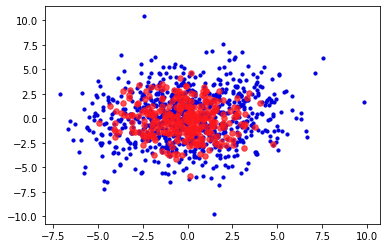

In [ ]:
fig, ax = plt.subplots()
#figure(figsize=(16, 12), dpi=80)
ax.scatter(V[0], V[1], s = 10, c = '#0101dd')
ax.scatter(C[0], C[1], s = 30, c = '#fc171c', alpha = 0.75)
plt.show()
fig.set_size_inches(10, 10)
fig.savefig('vcDistr.png', dpi=100)

# Voting

In [ ]:
VoteLists = np.zeros((Vamount, Camount))
distances = np.zeros((Vamount, Camount))
for i in range(Vamount):
  for j in range(Camount):
    distances[i][j] = ((V[0][i]-C[0][j])**2 + (V[1][i] - C[1][j])**2)
d1 = np.sort(distances, axis=1)
VoteLists = np.argsort(distances, axis=1)
#for i in range(Vamount):
  #d1[i][0] = ind[i][1]
  #VoteLists[i] = ind[i]
print(VoteLists)

[[ 16 136  54 ... 120 127   1]
 [189  43 186 ... 184 205  88]
 [ 75 297 183 ... 101 288  88]
 ...
 [ 88 184 205 ... 245 246 127]
 [ 56 136 209 ... 187 120   1]
 [136  56 254 ... 187 120   1]]


Removed1 63
Removed2.1 0
Mean Dist is 0.2305936261308941
Removed3 20
Removed3.1 20


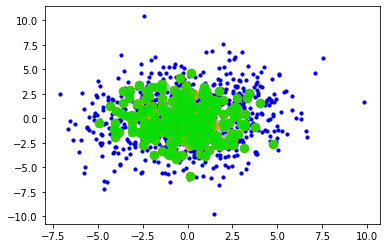

  1%|          | 2/300 [00:00<00:51,  5.79it/s]

0.746228118882509


  1%|▏         | 4/300 [00:00<00:53,  5.57it/s]

0.7749887105222959


 11%|█         | 33/300 [00:05<00:46,  5.73it/s]

0.7797427129285432


 13%|█▎        | 40/300 [00:06<00:45,  5.73it/s]

0.7819480690948711


 24%|██▍       | 73/300 [00:12<00:39,  5.77it/s]

0.783432893437868


 40%|████      | 120/300 [00:20<00:30,  5.85it/s]

0.7901697453251603


100%|██████████| 300/300 [00:51<00:00,  5.78it/s]


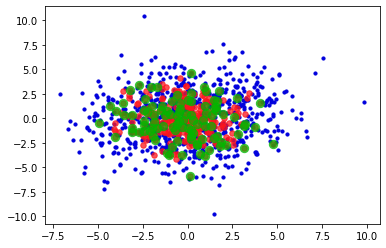

Score of Random is  0.7901697453251603
median Score of Random is  1.0
7 to 57
Score changed to 0.7905395619537018
57 to 102
Score changed to 0.7911551104774301
102 to 212
Score changed to 0.7928711987080855
15 to 2
Score changed to 0.7933097568341231
2 to 264
Score changed to 0.7933971803224766
18 to 11
Score changed to 0.7934375106374921
11 to 49
Score changed to 0.7943507651359158
19 to 180
Score changed to 0.7951158792439894
180 to 192
Score changed to 0.795684699469559
20 to 144
Score changed to 0.7972153158611169
25 to 4
Score changed to 0.7988428084207044
29 to 36
Score changed to 0.7996844274304845
36 to 242
Score changed to 0.800229926797397
41 to 6
Score changed to 0.8021402966968081
54 to 130
Score changed to 0.8024206097124538
130 to 236
Score changed to 0.8025519917090961
59 to 52
Score changed to 0.8085935232692455
69 to 91
Score changed to 0.8112454801995671
91 to 257
Score changed to 0.8119704861594292
70 to 0
Score changed to 0.8130117802635647
0 to 188
Score changed to

In [ ]:
OptC = Opt(VoteLists, Vamount, Camount, ComAmount, C, V, d1)

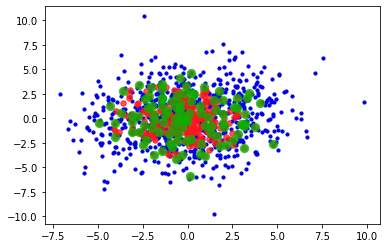

Score of SNTV rule is  0.8657536178054781
median Score of SNTV rule is  1.0


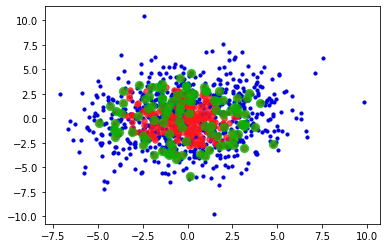

Score of STV rule is  0.8143481582993379
median Score of STV rule is  1.0


In [ ]:
CP = Plurality_Score(VoteLists, Vamount, Camount, ComAmount, C, V, d1)
CS = STV(VoteLists, Vamount, Camount, ComAmount, C, V, d1)

In [ ]:
a = np.zeros((3, 10))
a[1][0] = 1
a

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
fg = np.array([[1, 2], [3, 4], [2,1]])
fg.T

array([[1, 3, 2],
       [2, 4, 1]])

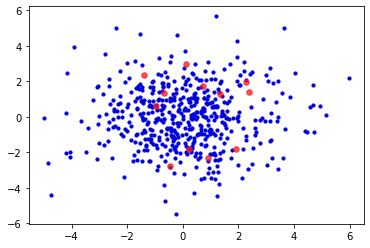

100 now


100%|██████████| 4096/4096 [00:00<00:00, 130611.62it/s]


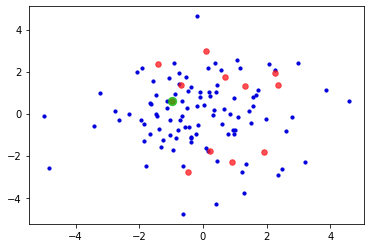

Score of Random is  0.6019237893613446
median Score of Random is  0.5281766101727208
1 done Score is 0.6019237893613446


100%|██████████| 4096/4096 [00:00<00:00, 51938.08it/s]


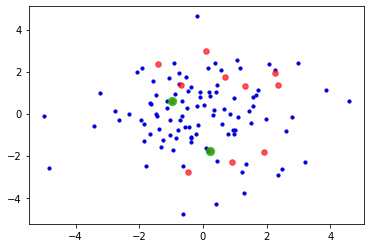

Score of Random is  0.7213057358830025
median Score of Random is  0.889303889712082
2 done Score is 0.7213057358830025


100%|██████████| 4096/4096 [00:00<00:00, 16074.79it/s]


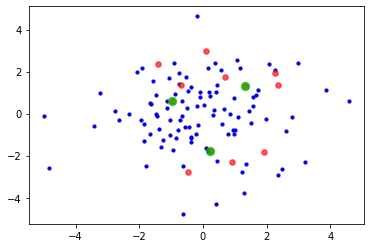

Score of Random is  0.804404110669432
median Score of Random is  1.0
3 done Score is 0.804404110669432


100%|██████████| 4096/4096 [00:00<00:00, 4301.60it/s]


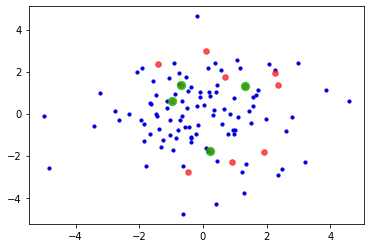

Score of Random is  0.8557183701606464
median Score of Random is  1.0
4 done Score is 0.8557183701606464


100%|██████████| 4096/4096 [00:02<00:00, 1409.19it/s]


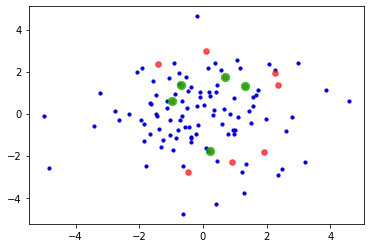

Score of Random is  0.8852881315426498
median Score of Random is  1.0
5 done Score is 0.8852881315426498


100%|██████████| 4096/4096 [00:01<00:00, 2379.35it/s]


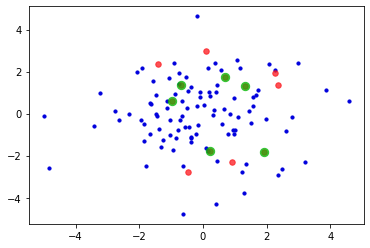

Score of Random is  0.9142936437595863
median Score of Random is  1.0
6 done Score is 0.9142936437595863


100%|██████████| 4096/4096 [00:01<00:00, 2792.66it/s]


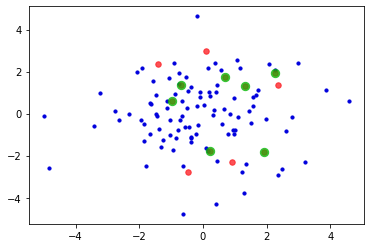

Score of Random is  0.9395876245783664
median Score of Random is  1.0
7 done Score is 0.9395876245783664


100%|██████████| 4096/4096 [00:01<00:00, 4063.70it/s]


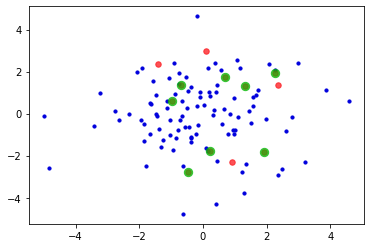

Score of Random is  0.9591295070295878
median Score of Random is  1.0
8 done Score is 0.9591295070295878


100%|██████████| 4096/4096 [00:00<00:00, 8048.44it/s]


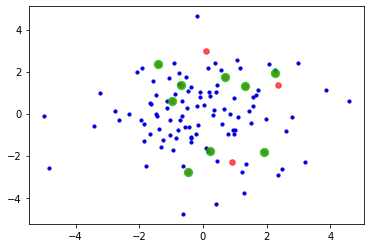

Score of Random is  0.9779699344364965
median Score of Random is  1.0
9 done Score is 0.9779699344364965


100%|██████████| 4096/4096 [00:00<00:00, 23072.77it/s]


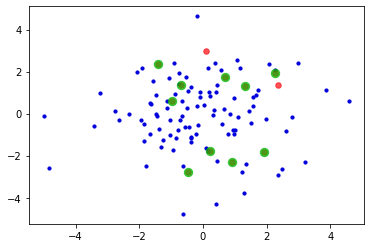

Score of Random is  0.991164310830888
median Score of Random is  1.0
10 done Score is 0.991164310830888


100%|██████████| 4096/4096 [00:00<00:00, 72061.09it/s]


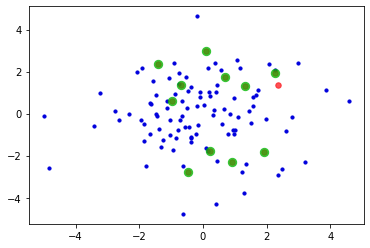

Score of Random is  0.9956386008853536
median Score of Random is  1.0
11 done Score is 0.9956386008853536


100%|██████████| 4096/4096 [00:00<00:00, 141787.87it/s]


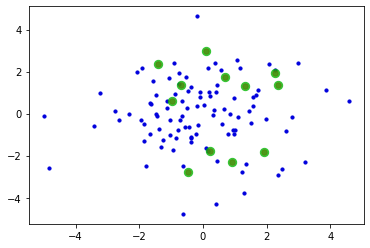

Score of Random is  1.0
median Score of Random is  1.0
12 done Score is 1.0


<ipython-input-38-03496911c2c4>:242: RuntimeWarning: divide by zero encountered in power
  [a0[i], b0[i]], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)


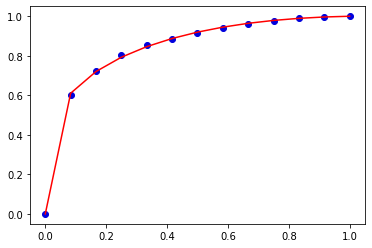

MaxScore(k)
-0.18644339422414133 0.2141065538675463
150 now


100%|██████████| 4096/4096 [00:00<00:00, 86470.92it/s]


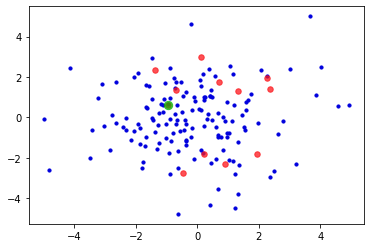

Score of Random is  0.6137297600704545
median Score of Random is  0.532912444241938
1 done Score is 0.6137297600704545


100%|██████████| 4096/4096 [00:00<00:00, 38366.93it/s]


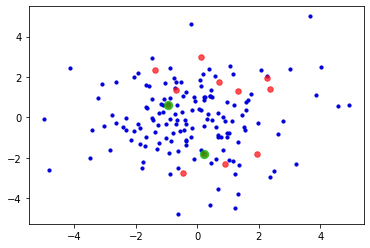

Score of Random is  0.73812075686558
median Score of Random is  0.8761601759917931
2 done Score is 0.73812075686558


100%|██████████| 4096/4096 [00:00<00:00, 10892.97it/s]


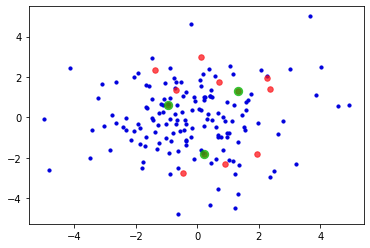

Score of Random is  0.8094930539115177
median Score of Random is  1.0
3 done Score is 0.8094930539115177


100%|██████████| 4096/4096 [00:00<00:00, 4158.37it/s]


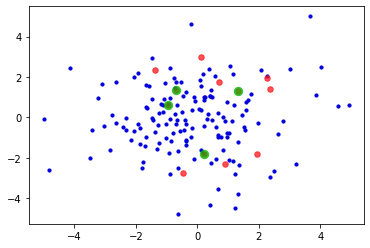

Score of Random is  0.8537317514325332
median Score of Random is  1.0
4 done Score is 0.8537317514325332


100%|██████████| 4096/4096 [00:01<00:00, 2353.54it/s]


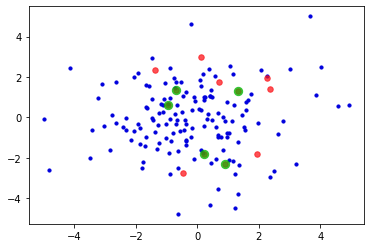

Score of Random is  0.8848932506156215
median Score of Random is  1.0
5 done Score is 0.8848932506156215


100%|██████████| 4096/4096 [00:02<00:00, 1765.43it/s]


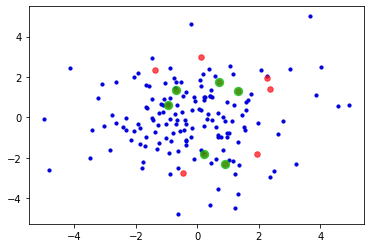

Score of Random is  0.9111986352811908
median Score of Random is  1.0
6 done Score is 0.9111986352811908


100%|██████████| 4096/4096 [00:02<00:00, 1874.08it/s]


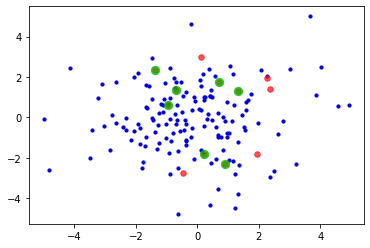

Score of Random is  0.9349100377350165
median Score of Random is  1.0
7 done Score is 0.9349100377350165


100%|██████████| 4096/4096 [00:01<00:00, 2699.55it/s]


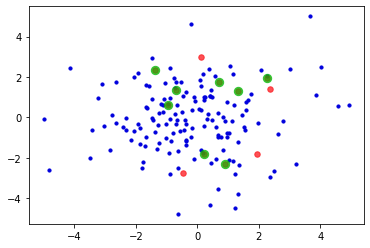

Score of Random is  0.956890292857586
median Score of Random is  1.0
8 done Score is 0.956890292857586


100%|██████████| 4096/4096 [00:00<00:00, 5298.21it/s]


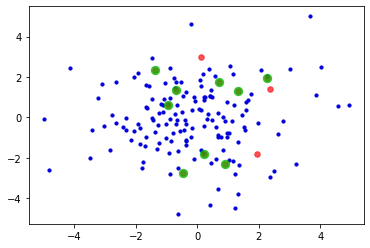

Score of Random is  0.977061708866352
median Score of Random is  1.0
9 done Score is 0.977061708866352


100%|██████████| 4096/4096 [00:00<00:00, 14880.70it/s]


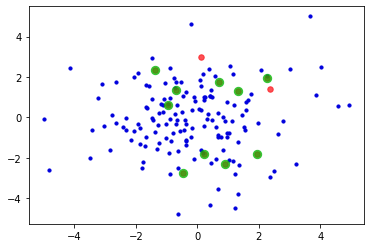

Score of Random is  0.9933992417058181
median Score of Random is  1.0
10 done Score is 0.9933992417058181


100%|██████████| 4096/4096 [00:00<00:00, 56854.79it/s]


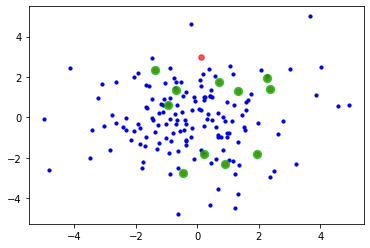

Score of Random is  0.9970171399636898
median Score of Random is  1.0
11 done Score is 0.9970171399636898


100%|██████████| 4096/4096 [00:00<00:00, 126217.70it/s]


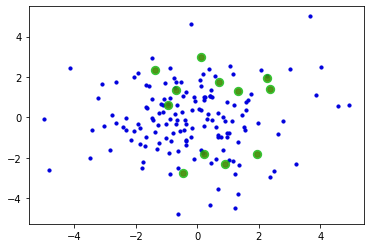

Score of Random is  1.0
median Score of Random is  1.0
12 done Score is 1.0


<ipython-input-38-03496911c2c4>:242: RuntimeWarning: divide by zero encountered in power
  [a0[i], b0[i]], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)


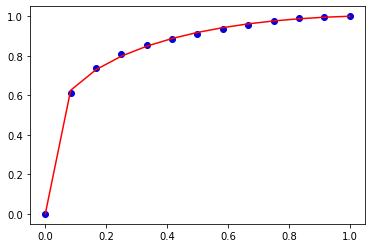

MaxScore(k)
-0.1574503648879234 0.20203797597704318
200 now


100%|██████████| 4096/4096 [00:00<00:00, 96738.40it/s]


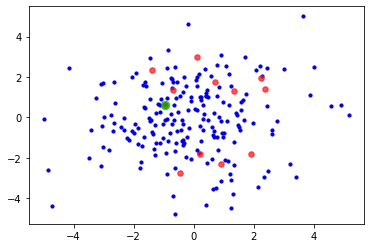

Score of Random is  0.5913324121421063
median Score of Random is  0.516129796608675
1 done Score is 0.5913324121421063


100%|██████████| 4096/4096 [00:00<00:00, 29317.28it/s]


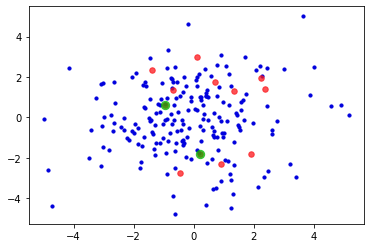

Score of Random is  0.7171929618784574
median Score of Random is  0.7938425881950107
2 done Score is 0.7171929618784574


100%|██████████| 4096/4096 [00:00<00:00, 8553.19it/s]


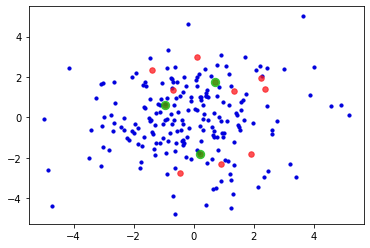

Score of Random is  0.7984879331373128
median Score of Random is  0.9841118883477417
3 done Score is 0.7984879331373128


100%|██████████| 4096/4096 [00:01<00:00, 3242.79it/s]


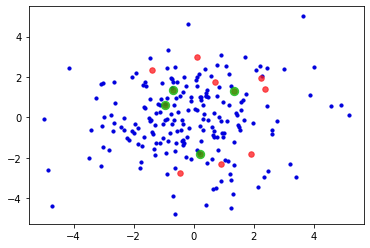

Score of Random is  0.8434299954949418
median Score of Random is  1.0
4 done Score is 0.8434299954949418


100%|██████████| 4096/4096 [00:02<00:00, 1754.05it/s]


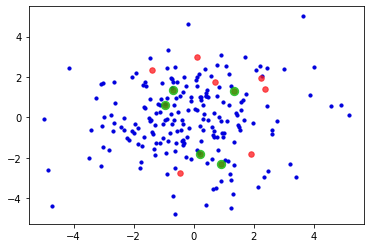

Score of Random is  0.8758409774698405
median Score of Random is  1.0
5 done Score is 0.8758409774698405


100%|██████████| 4096/4096 [00:03<00:00, 1326.35it/s]


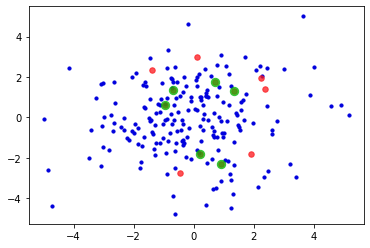

Score of Random is  0.903880580301297
median Score of Random is  1.0
6 done Score is 0.903880580301297


100%|██████████| 4096/4096 [00:02<00:00, 1387.28it/s]


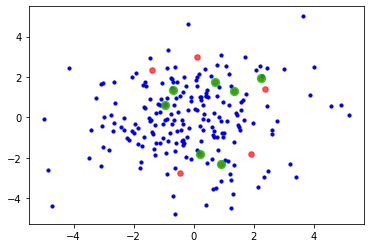

Score of Random is  0.9286257290596401
median Score of Random is  1.0
7 done Score is 0.9286257290596401


100%|██████████| 4096/4096 [00:02<00:00, 2011.09it/s]


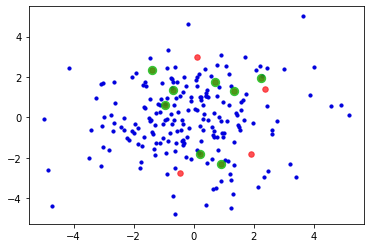

Score of Random is  0.9530962976395618
median Score of Random is  1.0
8 done Score is 0.9530962976395618


100%|██████████| 4096/4096 [00:00<00:00, 4201.67it/s]


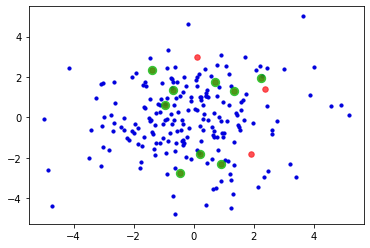

Score of Random is  0.9736146025291981
median Score of Random is  1.0
9 done Score is 0.9736146025291981


100%|██████████| 4096/4096 [00:00<00:00, 11871.49it/s]


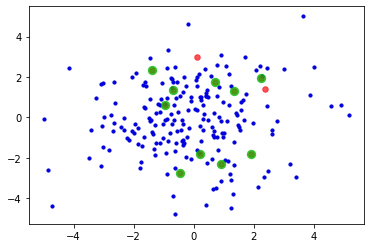

Score of Random is  0.9898873728231183
median Score of Random is  1.0
10 done Score is 0.9898873728231183


100%|██████████| 4096/4096 [00:00<00:00, 45830.46it/s]


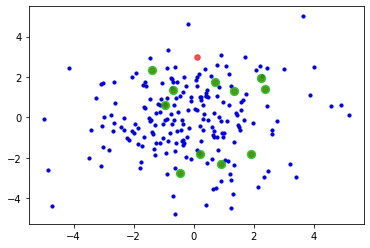

Score of Random is  0.9950839800087331
median Score of Random is  1.0
11 done Score is 0.9950839800087331


100%|██████████| 4096/4096 [00:00<00:00, 121489.78it/s]


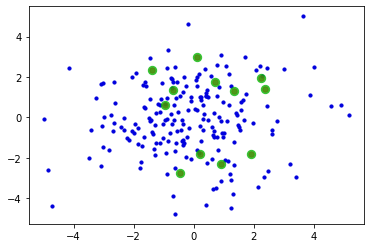

Score of Random is  1.0
median Score of Random is  1.0
12 done Score is 1.0


<ipython-input-38-03496911c2c4>:242: RuntimeWarning: divide by zero encountered in power
  [a0[i], b0[i]], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)


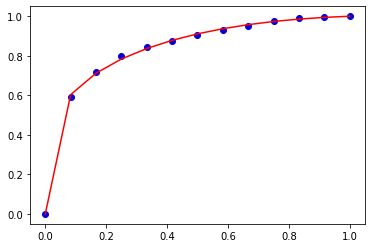

MaxScore(k)
-0.1646485670482592 0.21707764550857636
250 now


100%|██████████| 4096/4096 [00:00<00:00, 100129.79it/s]


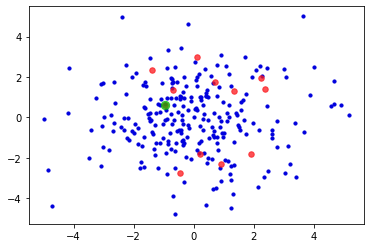

Score of Random is  0.5782536050483377
median Score of Random is  0.4988783950068311
1 done Score is 0.5782536050483377


100%|██████████| 4096/4096 [00:00<00:00, 25521.95it/s]


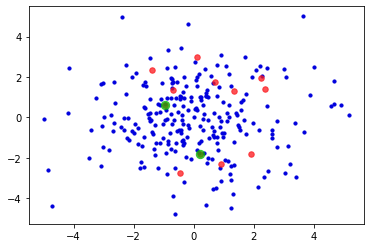

Score of Random is  0.709784621235957
median Score of Random is  0.7737956676446254
2 done Score is 0.709784621235957


100%|██████████| 4096/4096 [00:00<00:00, 6853.46it/s]


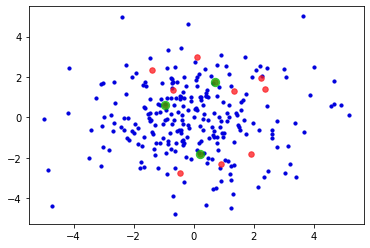

Score of Random is  0.7831234315864595
median Score of Random is  0.960100578402827
3 done Score is 0.7831234315864595


100%|██████████| 4096/4096 [00:01<00:00, 2576.78it/s]


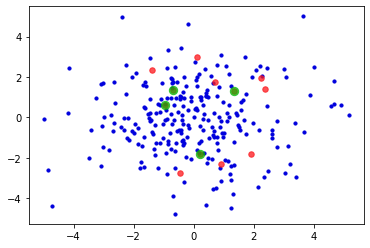

Score of Random is  0.8268505340215706
median Score of Random is  1.0
4 done Score is 0.8268505340215706


100%|██████████| 4096/4096 [00:02<00:00, 1405.56it/s]


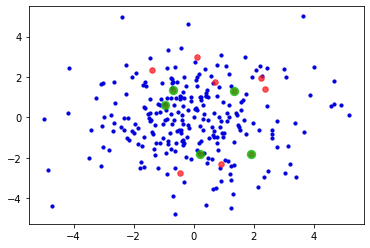

Score of Random is  0.8620939395783584
median Score of Random is  1.0
5 done Score is 0.8620939395783584


100%|██████████| 4096/4096 [00:03<00:00, 1056.87it/s]


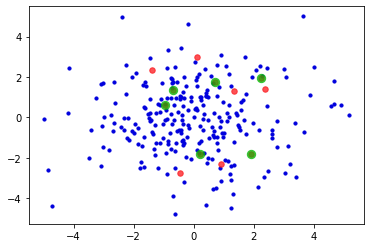

Score of Random is  0.8921828532174687
median Score of Random is  1.0
6 done Score is 0.8921828532174687


100%|██████████| 4096/4096 [00:03<00:00, 1113.75it/s]


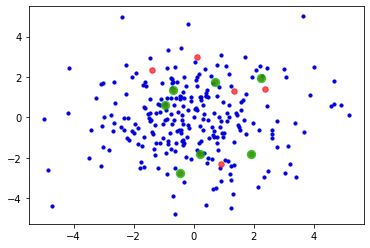

Score of Random is  0.9180440970909584
median Score of Random is  1.0
7 done Score is 0.9180440970909584


100%|██████████| 4096/4096 [00:02<00:00, 1636.58it/s]


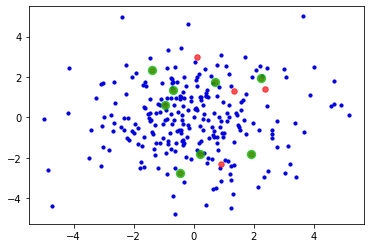

Score of Random is  0.941518309498326
median Score of Random is  1.0
8 done Score is 0.941518309498326


100%|██████████| 4096/4096 [00:01<00:00, 3307.52it/s]


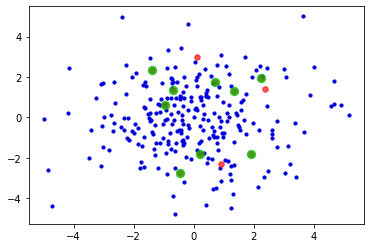

Score of Random is  0.9639889614346147
median Score of Random is  1.0
9 done Score is 0.9639889614346147


100%|██████████| 4096/4096 [00:00<00:00, 9879.14it/s] 


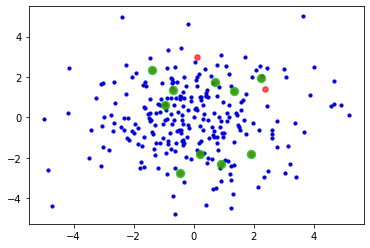

Score of Random is  0.9855838946893251
median Score of Random is  1.0
10 done Score is 0.9855838946893251


100%|██████████| 4096/4096 [00:00<00:00, 36493.59it/s]


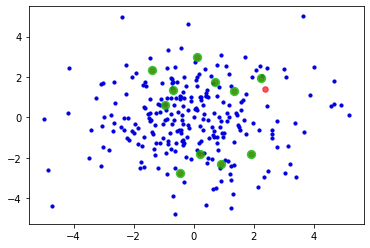

Score of Random is  0.9948179764376943
median Score of Random is  1.0
11 done Score is 0.9948179764376943


100%|██████████| 4096/4096 [00:00<00:00, 110702.88it/s]


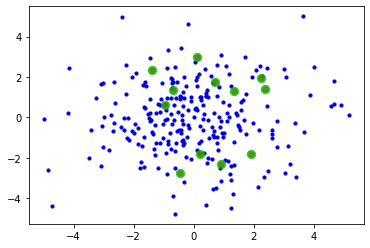

Score of Random is  1.0
median Score of Random is  1.0
12 done Score is 1.0


<ipython-input-38-03496911c2c4>:242: RuntimeWarning: divide by zero encountered in power
  [a0[i], b0[i]], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)


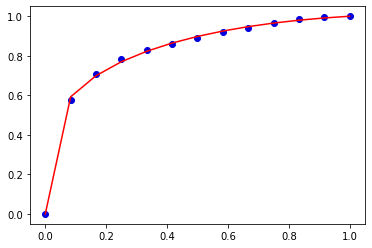

MaxScore(k)
-0.13255295140927403 0.22173807556118058
300 now


100%|██████████| 4096/4096 [00:00<00:00, 70635.39it/s]


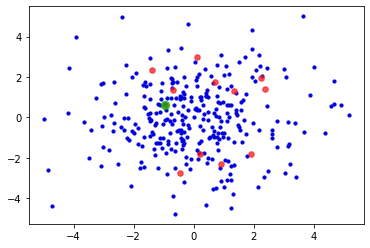

Score of Random is  0.5661620608961747
median Score of Random is  0.4945831570335071
1 done Score is 0.5661620608961747


100%|██████████| 4096/4096 [00:00<00:00, 21240.79it/s]


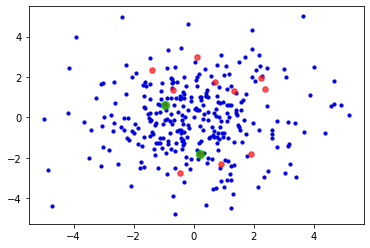

Score of Random is  0.7011976457056702
median Score of Random is  0.7528274960179404
2 done Score is 0.7011976457056702


100%|██████████| 4096/4096 [00:00<00:00, 5453.21it/s]


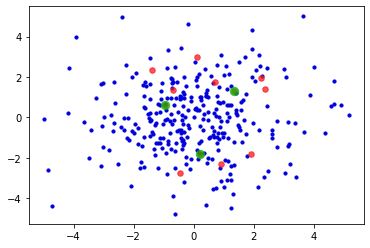

Score of Random is  0.7879021817356098
median Score of Random is  0.9801045408088782
3 done Score is 0.7879021817356098


100%|██████████| 4096/4096 [00:01<00:00, 2172.13it/s]


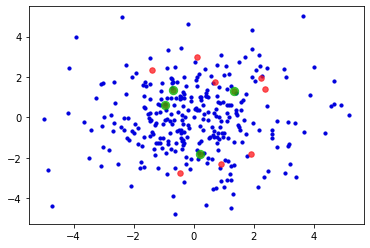

Score of Random is  0.8298234409950902
median Score of Random is  1.0
4 done Score is 0.8298234409950902


100%|██████████| 4096/4096 [00:03<00:00, 1140.71it/s]


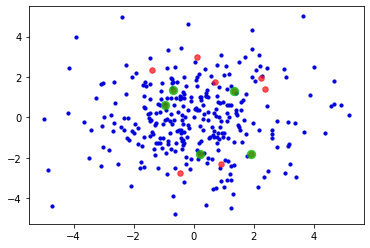

Score of Random is  0.867517825346082
median Score of Random is  1.0
5 done Score is 0.867517825346082


100%|██████████| 4096/4096 [00:04<00:00, 863.68it/s]


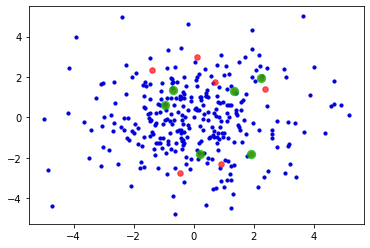

Score of Random is  0.8960678264496565
median Score of Random is  1.0
6 done Score is 0.8960678264496565


100%|██████████| 4096/4096 [00:04<00:00, 906.36it/s]


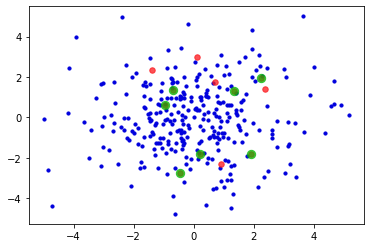

Score of Random is  0.9225951199777617
median Score of Random is  1.0
7 done Score is 0.9225951199777617


100%|██████████| 4096/4096 [00:03<00:00, 1343.31it/s]


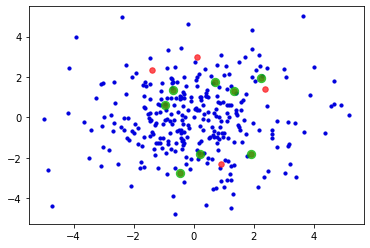

Score of Random is  0.9457484310738637
median Score of Random is  1.0
8 done Score is 0.9457484310738637


100%|██████████| 4096/4096 [00:01<00:00, 2758.59it/s]


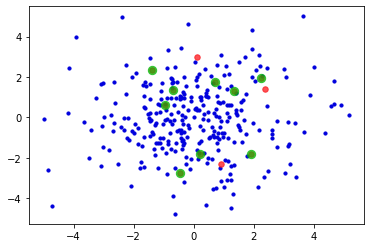

Score of Random is  0.966827540480203
median Score of Random is  1.0
9 done Score is 0.966827540480203


100%|██████████| 4096/4096 [00:00<00:00, 8121.25it/s] 


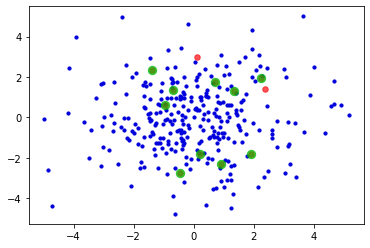

Score of Random is  0.987443488046877
median Score of Random is  1.0
10 done Score is 0.987443488046877


100%|██████████| 4096/4096 [00:00<00:00, 30891.27it/s]


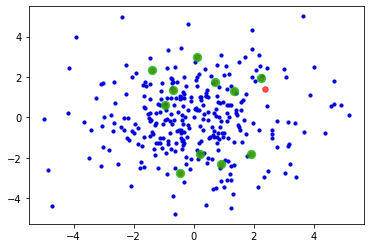

Score of Random is  0.9952950082603921
median Score of Random is  1.0
11 done Score is 0.9952950082603921


100%|██████████| 4096/4096 [00:00<00:00, 96192.95it/s]


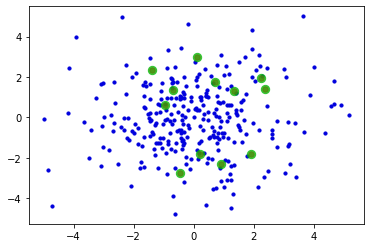

Score of Random is  1.0
median Score of Random is  1.0
12 done Score is 1.0


<ipython-input-38-03496911c2c4>:242: RuntimeWarning: divide by zero encountered in power
  [a0[i], b0[i]], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)


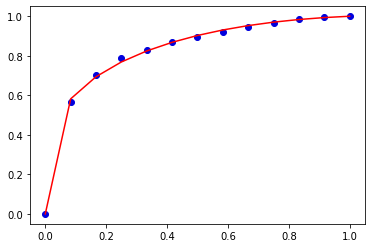

MaxScore(k)
-0.1685461210290218 0.23188438483522436
350 now


100%|██████████| 4096/4096 [00:00<00:00, 77344.29it/s]


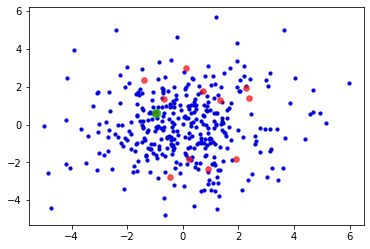

Score of Random is  0.5580498691987501
median Score of Random is  0.49507650660169483
1 done Score is 0.5580498691987501


100%|██████████| 4096/4096 [00:00<00:00, 16604.54it/s]


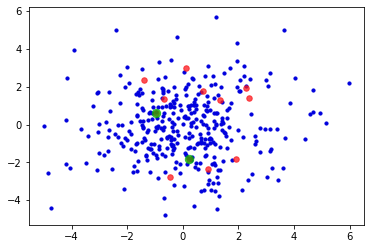

Score of Random is  0.6994495218978676
median Score of Random is  0.7475581899537009
2 done Score is 0.6994495218978676


100%|██████████| 4096/4096 [00:00<00:00, 4620.88it/s]


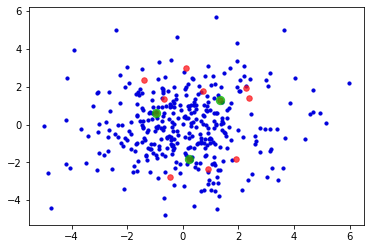

Score of Random is  0.7897912323646122
median Score of Random is  0.9841118883477417
3 done Score is 0.7897912323646122


100%|██████████| 4096/4096 [00:02<00:00, 1824.13it/s]


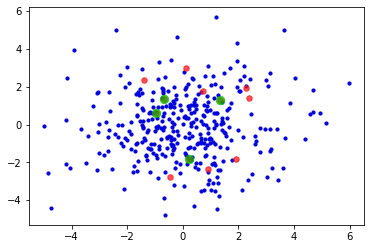

Score of Random is  0.8281276668170553
median Score of Random is  1.0
4 done Score is 0.8281276668170553


100%|██████████| 4096/4096 [00:04<00:00, 990.28it/s] 


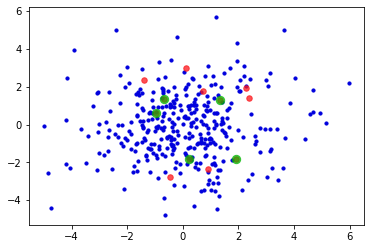

Score of Random is  0.8645023808540409
median Score of Random is  1.0
5 done Score is 0.8645023808540409


100%|██████████| 4096/4096 [00:05<00:00, 736.40it/s]


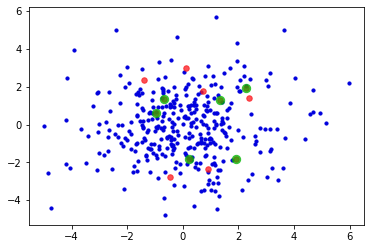

Score of Random is  0.8930743272746997
median Score of Random is  1.0
6 done Score is 0.8930743272746997


100%|██████████| 4096/4096 [00:05<00:00, 778.24it/s]


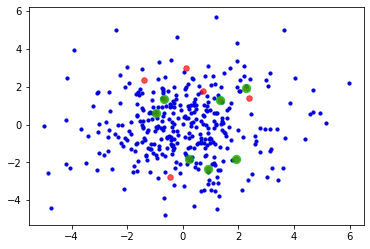

Score of Random is  0.9195222686893466
median Score of Random is  1.0
7 done Score is 0.9195222686893466


100%|██████████| 4096/4096 [00:03<00:00, 1148.24it/s]


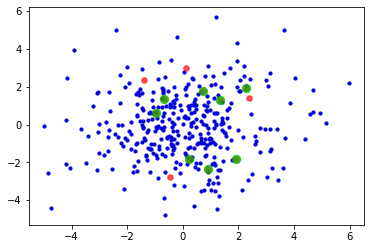

Score of Random is  0.9429877256806247
median Score of Random is  1.0
8 done Score is 0.9429877256806247


100%|██████████| 4096/4096 [00:01<00:00, 2379.13it/s]


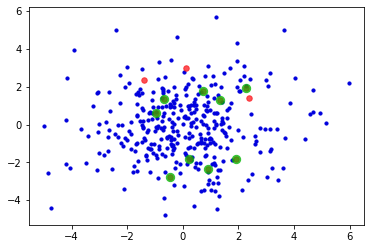

Score of Random is  0.9661168204498807
median Score of Random is  1.0
9 done Score is 0.9661168204498807


100%|██████████| 4096/4096 [00:00<00:00, 6710.09it/s]


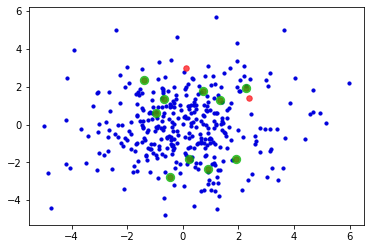

Score of Random is  0.9872378944468253
median Score of Random is  1.0
10 done Score is 0.9872378944468253


100%|██████████| 4096/4096 [00:00<00:00, 25404.16it/s]


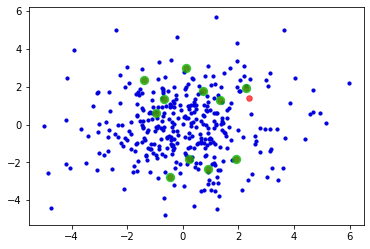

Score of Random is  0.9956623362465817
median Score of Random is  1.0
11 done Score is 0.9956623362465817


100%|██████████| 4096/4096 [00:00<00:00, 77630.18it/s]


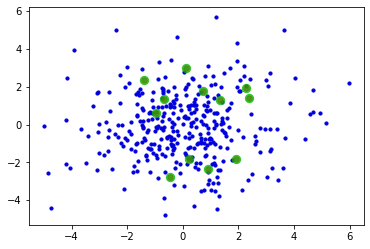

Score of Random is  1.0
median Score of Random is  1.0
12 done Score is 1.0


<ipython-input-38-03496911c2c4>:242: RuntimeWarning: divide by zero encountered in power
  [a0[i], b0[i]], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)


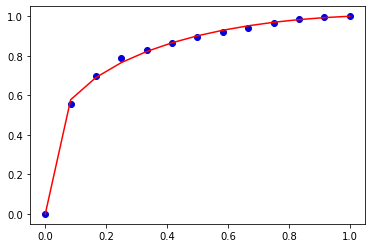

MaxScore(k)
-0.16885140093571363 0.23484125076290718
400 now


100%|██████████| 4096/4096 [00:00<00:00, 65974.16it/s]


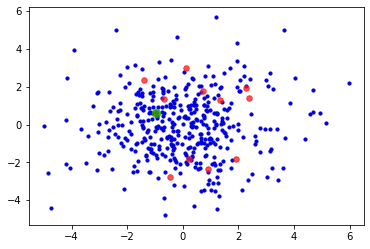

Score of Random is  0.5640509389146814
median Score of Random is  0.4986499551577717
1 done Score is 0.5640509389146814


100%|██████████| 4096/4096 [00:00<00:00, 15840.54it/s]


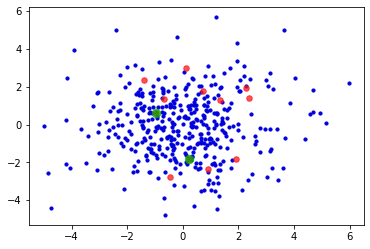

Score of Random is  0.7074128670199399
median Score of Random is  0.7723473603712658
2 done Score is 0.7074128670199399


100%|██████████| 4096/4096 [00:00<00:00, 4203.26it/s]


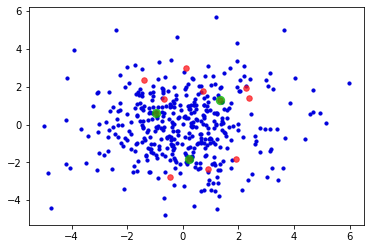

Score of Random is  0.7991846090207456
median Score of Random is  1.0
3 done Score is 0.7991846090207456


100%|██████████| 4096/4096 [00:02<00:00, 1575.98it/s]


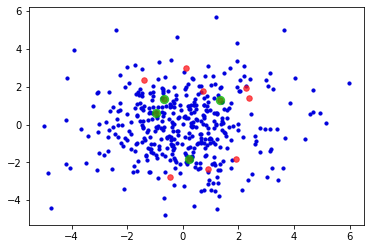

Score of Random is  0.8370671974772038
median Score of Random is  1.0
4 done Score is 0.8370671974772038


100%|██████████| 4096/4096 [00:04<00:00, 853.40it/s] 


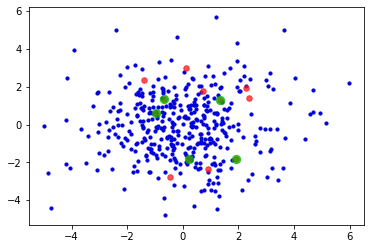

Score of Random is  0.8718786715533361
median Score of Random is  1.0
5 done Score is 0.8718786715533361


100%|██████████| 4096/4096 [00:06<00:00, 643.36it/s]


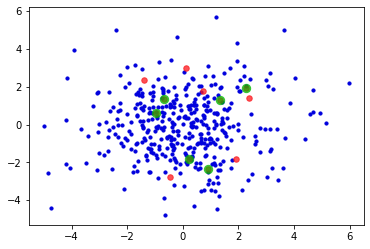

Score of Random is  0.8984107310924455
median Score of Random is  1.0
6 done Score is 0.8984107310924455


100%|██████████| 4096/4096 [00:06<00:00, 670.79it/s]


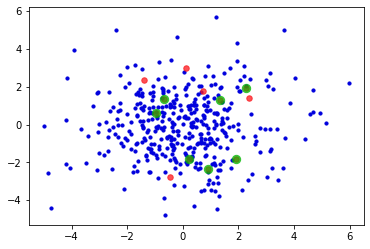

Score of Random is  0.9230682970839773
median Score of Random is  1.0
7 done Score is 0.9230682970839773


100%|██████████| 4096/4096 [00:04<00:00, 983.27it/s]


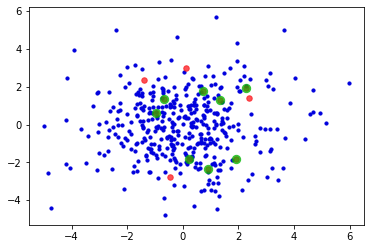

Score of Random is  0.9463400949272972
median Score of Random is  1.0
8 done Score is 0.9463400949272972


100%|██████████| 4096/4096 [00:01<00:00, 2084.62it/s]


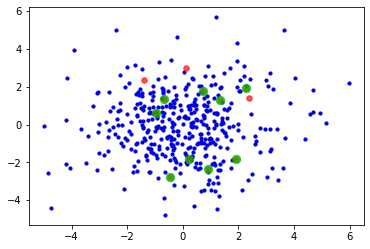

Score of Random is  0.9678374796384702
median Score of Random is  1.0
9 done Score is 0.9678374796384702


100%|██████████| 4096/4096 [00:00<00:00, 6048.98it/s]


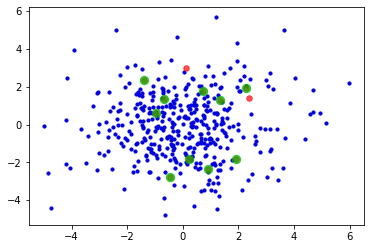

Score of Random is  0.988758515105433
median Score of Random is  1.0
10 done Score is 0.988758515105433


100%|██████████| 4096/4096 [00:00<00:00, 22745.79it/s]


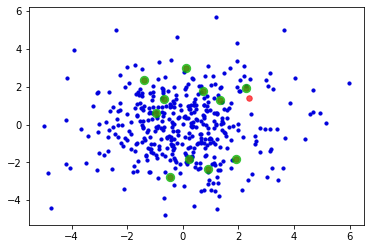

Score of Random is  0.9961299016802198
median Score of Random is  1.0
11 done Score is 0.9961299016802198


100%|██████████| 4096/4096 [00:00<00:00, 78995.17it/s]


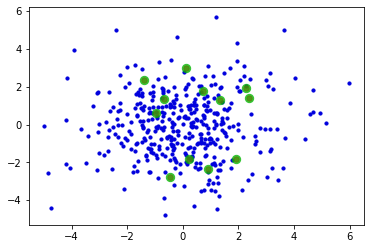

Score of Random is  1.0
median Score of Random is  1.0
12 done Score is 1.0


<ipython-input-38-03496911c2c4>:242: RuntimeWarning: divide by zero encountered in power
  [a0[i], b0[i]], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)


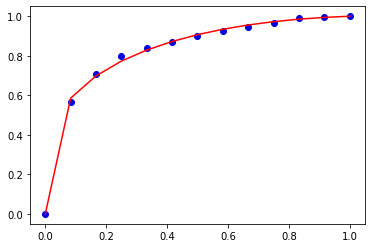

MaxScore(k)
-0.1777592298021226 0.23008076347844875
450 now


100%|██████████| 4096/4096 [00:00<00:00, 56777.94it/s]


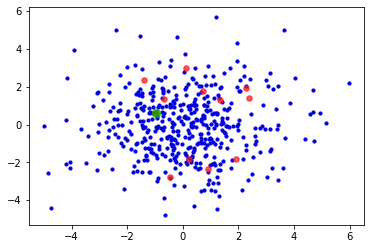

Score of Random is  0.5506623942251468
median Score of Random is  0.4940426912384257
1 done Score is 0.5506623942251468


100%|██████████| 4096/4096 [00:00<00:00, 13299.06it/s]


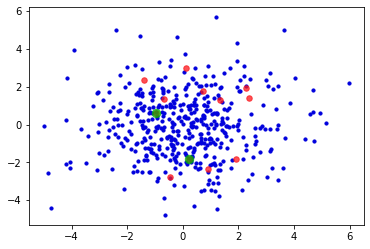

Score of Random is  0.6920349128371786
median Score of Random is  0.7321588427291925
2 done Score is 0.6920349128371786


100%|██████████| 4096/4096 [00:01<00:00, 3613.34it/s]


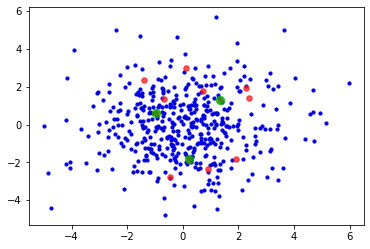

Score of Random is  0.7875375010038403
median Score of Random is  1.0
3 done Score is 0.7875375010038403


100%|██████████| 4096/4096 [00:02<00:00, 1410.93it/s]


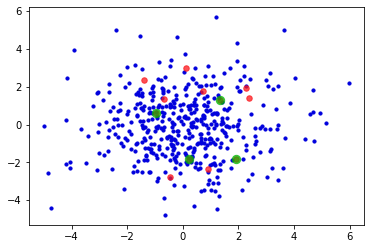

Score of Random is  0.8265742448948944
median Score of Random is  1.0
4 done Score is 0.8265742448948944


100%|██████████| 4096/4096 [00:05<00:00, 758.80it/s] 


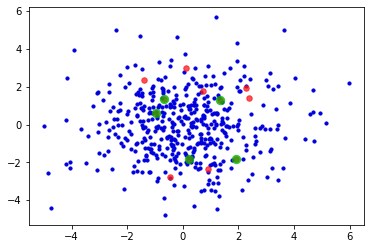

Score of Random is  0.8633296561744668
median Score of Random is  1.0
5 done Score is 0.8633296561744668


100%|██████████| 4096/4096 [00:07<00:00, 564.62it/s]


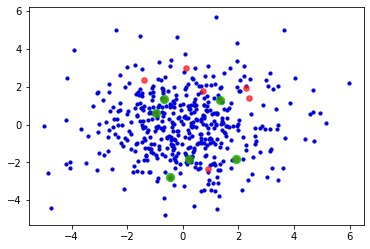

Score of Random is  0.8897672524575063
median Score of Random is  1.0
6 done Score is 0.8897672524575063


100%|██████████| 4096/4096 [00:06<00:00, 586.87it/s]


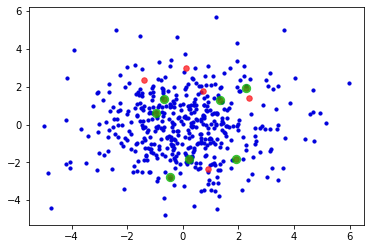

Score of Random is  0.9149544122875632
median Score of Random is  1.0
7 done Score is 0.9149544122875632


100%|██████████| 4096/4096 [00:04<00:00, 867.14it/s]


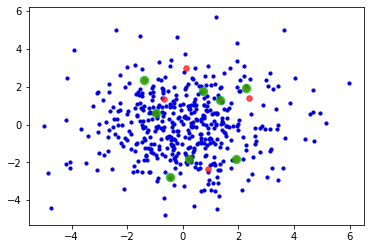

Score of Random is  0.9391721817282028
median Score of Random is  1.0
8 done Score is 0.9391721817282028


100%|██████████| 4096/4096 [00:02<00:00, 1821.51it/s]


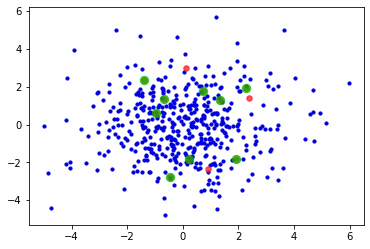

Score of Random is  0.9610379676965616
median Score of Random is  1.0
9 done Score is 0.9610379676965616


100%|██████████| 4096/4096 [00:00<00:00, 5408.42it/s]


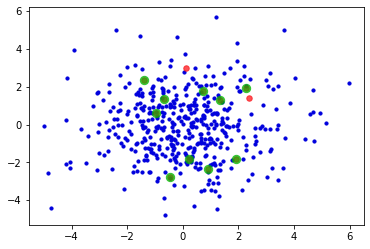

Score of Random is  0.9827495444125022
median Score of Random is  1.0
10 done Score is 0.9827495444125022


100%|██████████| 4096/4096 [00:00<00:00, 22039.23it/s]


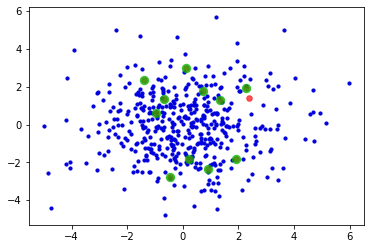

Score of Random is  0.9934884977261197
median Score of Random is  1.0
11 done Score is 0.9934884977261197


100%|██████████| 4096/4096 [00:00<00:00, 74482.00it/s]


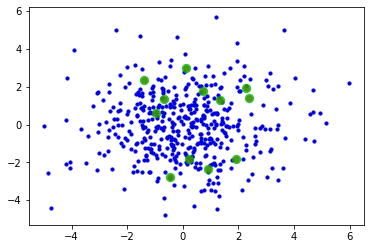

Score of Random is  1.0
median Score of Random is  1.0
12 done Score is 1.0


<ipython-input-38-03496911c2c4>:242: RuntimeWarning: divide by zero encountered in power
  [a0[i], b0[i]], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)


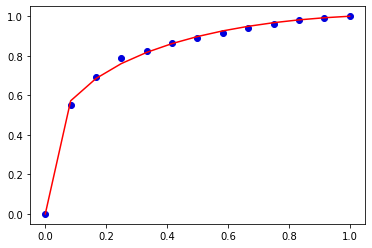

MaxScore(k)
-0.16406140168935462 0.2383142791693945
500 now


100%|██████████| 4096/4096 [00:00<00:00, 54326.79it/s]


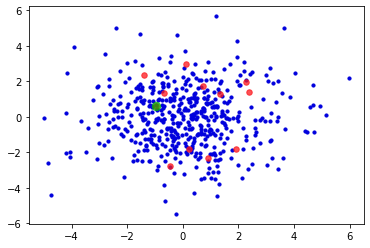

Score of Random is  0.5504740005327746
median Score of Random is  0.48901060039563027
1 done Score is 0.5504740005327746


100%|██████████| 4096/4096 [00:00<00:00, 12422.77it/s]


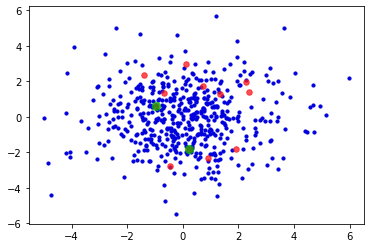

Score of Random is  0.6908641387660305
median Score of Random is  0.7320004397812323
2 done Score is 0.6908641387660305


100%|██████████| 4096/4096 [00:01<00:00, 3250.82it/s]


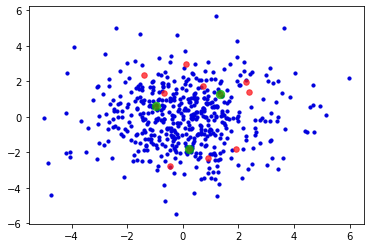

Score of Random is  0.7895333529373654
median Score of Random is  1.0
3 done Score is 0.7895333529373654


100%|██████████| 4096/4096 [00:03<00:00, 1224.16it/s]


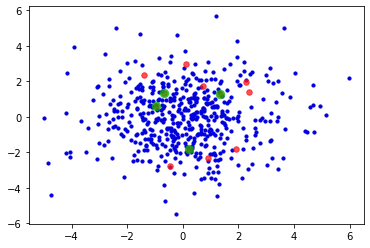

Score of Random is  0.8279752796513556
median Score of Random is  1.0
4 done Score is 0.8279752796513556


100%|██████████| 4096/4096 [00:06<00:00, 671.04it/s] 


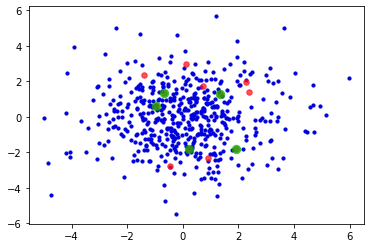

Score of Random is  0.8660127433504141
median Score of Random is  1.0
5 done Score is 0.8660127433504141


100%|██████████| 4096/4096 [00:08<00:00, 502.55it/s]


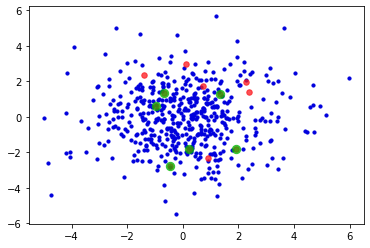

Score of Random is  0.8917438905642012
median Score of Random is  1.0
6 done Score is 0.8917438905642012


100%|██████████| 4096/4096 [00:07<00:00, 523.87it/s]


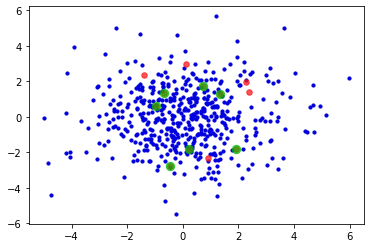

Score of Random is  0.9166071942994026
median Score of Random is  1.0
7 done Score is 0.9166071942994026


100%|██████████| 4096/4096 [00:05<00:00, 768.00it/s]


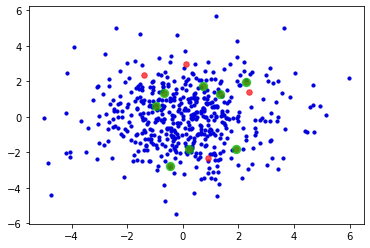

Score of Random is  0.9405690862999334
median Score of Random is  1.0
8 done Score is 0.9405690862999334


100%|██████████| 4096/4096 [00:02<00:00, 1653.87it/s]


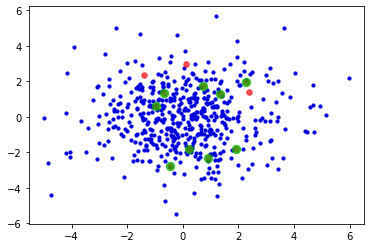

Score of Random is  0.962170582807602
median Score of Random is  1.0
9 done Score is 0.962170582807602


100%|██████████| 4096/4096 [00:00<00:00, 4905.48it/s]


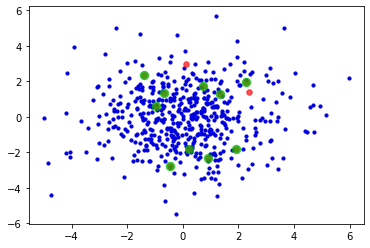

Score of Random is  0.983383311653791
median Score of Random is  1.0
10 done Score is 0.983383311653791


100%|██████████| 4096/4096 [00:00<00:00, 18779.45it/s]


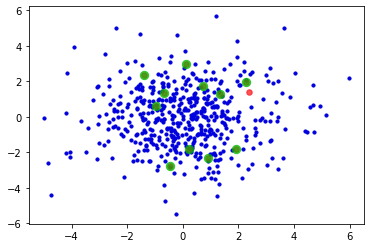

Score of Random is  0.9932440870360261
median Score of Random is  1.0
11 done Score is 0.9932440870360261


100%|██████████| 4096/4096 [00:00<00:00, 71220.45it/s]


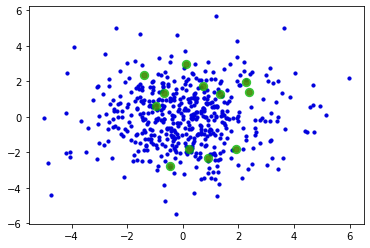

Score of Random is  1.0
median Score of Random is  1.0
12 done Score is 1.0


<ipython-input-38-03496911c2c4>:242: RuntimeWarning: divide by zero encountered in power
  [a0[i], b0[i]], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)


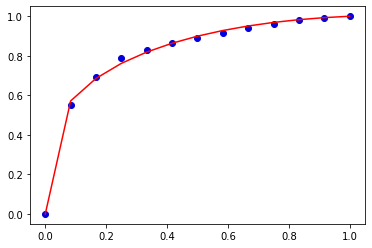

MaxScore(k)
-0.17211888143742185 0.23935905308101268


In [ ]:
M = 12

sss, A, B = testBFV(MMM = M, dist1 = 'normal', dist2 = 'radial2', b1 = 3, b2 = 3)

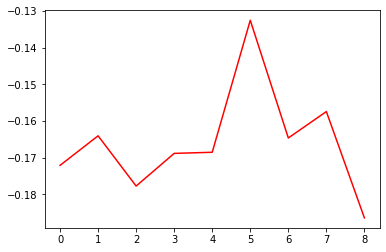

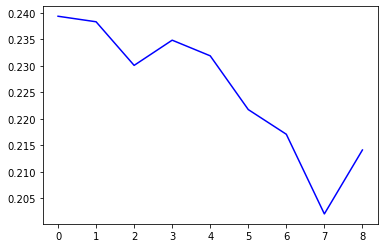

In [ ]:
Q = np.arange(9)
plt.plot(Q, A, 'r')
plt.show()
plt.plot(Q, B, 'B')
plt.show()

100%|██████████| 5000/5000 [5:48:55<00:00,  4.19s/it]

1.0 0.7301963294921041 0.6321835381229832
6.0 0.7329496402877698 0.6262257688339915
0.0 0.2937857317040128 0.5556212419592255


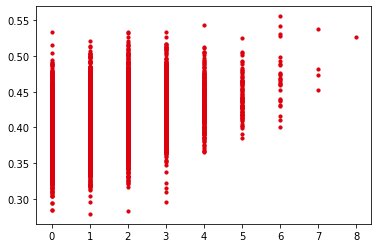

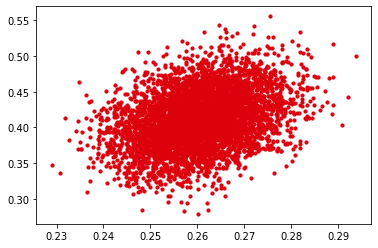

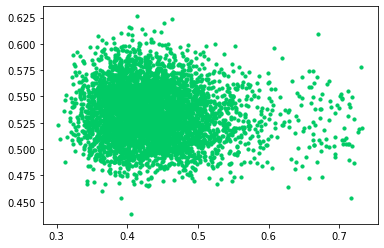

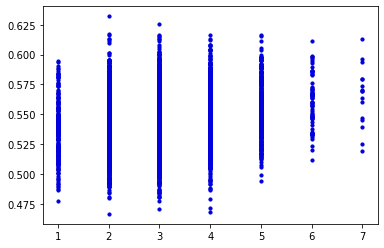

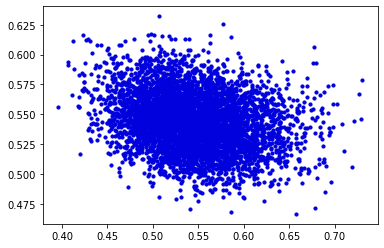

In [ ]:
test(Vq = 800, Cq = 250, Comq = 20, count = 5000, vers = 2)

In [ ]:
Ss0 = []
q = 20

for i in range(q):
  Ss0.append(TestAll(300, 80, 20, 'normal', 'normal', 7, 7))

cunt = np.arange(q)
Ss0 = np.transpose(np.array(Ss0))

fig, ax = plt.subplots()
ax.grid(True)
ax.scatter(cunt, Ss0[0], s = 40, c = '#0606cd', label='k-approval')
ax.scatter(cunt, Ss0[1], s = 20, c = '#620067', label='k-Borda')
ax.scatter(cunt, Ss0[2], s = 40, c = '#05e905', label='SNTV')
ax.scatter(cunt, Ss0[3], s = 25, c = '#fa010d', label='STV')
ax.scatter(cunt, Ss0[4], s = 15, c = '#edcd01', label='Rand Opt')
#ax.scatter(cunt, Ss0[5], s = 10, c = '#010901', label='SNTV Opt')
#ax.scatter(cunt, Ss0[6], s = 10, c = '#010901', label='SNTV full opt')
print("Ss0:")
ax.legend()
ax.set_ylabel('Score')
plt.show()
fig.set_size_inches(5, 5)
fig.savefig('Ss0(n).png', dpi=300)

fig, ax = plt.subplots()
ax.grid(True)
ax.scatter(cunt, Ss0[4], s = 80, c = '#edcd01', label='Rand Opt')
ax.scatter(cunt, Ss0[5], s = 50, c = '#0109dd', label='SNTV Opt')
ax.scatter(cunt, Ss0[6], s = 20, c = '#f700aa', label='SNTV full opt')
print("Ss0(Opt):")
ax.legend()
ax.set_ylabel('Score')
plt.show()
fig.set_size_inches(5, 5)
fig.savefig('Ss0(n)_Opt.png', dpi=300)

fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(Ss0.tolist(), labels = ['Bloc', 'Borda', 'SNTV', 'STV', 'RO', 'SNTVOP', 'SNTVO'])
ax.set_ylabel('Score')
ax.set_xlabel('Rule')
plt.show()
fig.set_size_inches(5, 5)
fig.savefig('Ss0.png', dpi=300)

DiffS = []
DiffS.append(Ss0[2] - Ss0[3])
for i in range(4,7):
  DiffS.append(Ss0[i] - Ss0[3])
DiffS = np.array(DiffS)
print("Diffs are:", DiffS)

fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(DiffS.tolist(), labels = ['SNTV', 'RO', 'SNTVOP', 'SNTVO'])
ax.set_ylabel('Score(Rule) - Score(STV)')
ax.set_xlabel('Rule')
plt.show()
fig.set_size_inches(7, 7)
fig.savefig('Ss0Diff.png', dpi=300)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Ss2 = []
q = 20

for i in range(q):
  Ss2.append(TestAll(300, 80, 60, 'normal', 'radial2', 7, 14))

cunt = np.arange(q)
Ss2 = np.transpose(np.array(Ss2))

fig, ax = plt.subplots()
ax.grid(True)
ax.scatter(cunt, Ss2[0], s = 40, c = '#0606cd', label='k-approval')
ax.scatter(cunt, Ss2[1], s = 20, c = '#620067', label='k-Borda')
ax.scatter(cunt, Ss2[2], s = 40, c = '#01e901', label='SNTV')
ax.scatter(cunt, Ss2[3], s = 25, c = '#fa010d', label='STV')
ax.scatter(cunt, Ss2[4], s = 15, c = '#edcd01', label='Rand Opt')
print("Ss2:")
ax.legend()
plt.show()
fig.set_size_inches(5, 5)
fig.savefig('Ss2(n).png', dpi=300)

fig, ax = plt.subplots()
ax.grid(True)
ax.scatter(cunt, Ss2[4], s = 80, c = '#edcd01', label='Rand Opt')
ax.scatter(cunt, Ss2[5], s = 50, c = '#0109dd', label='SNTV Opt')
ax.scatter(cunt, Ss2[6], s = 20, c = '#f700aa', label='SNTV full opt')
print("Ss2(Opt):")
ax.legend()
plt.show()
fig.set_size_inches(5, 5)
fig.savefig('Ss2(n)_Opt.png', dpi=300)

fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(Ss2.tolist(), labels = ['Bloc', 'Borda', 'SNTV', 'STV', 'RO', 'SNTVOP', 'SNTVO'])
ax.set_ylabel('Score')
ax.set_xlabel('Rule')
plt.show()
fig.set_size_inches(5, 5)
fig.savefig('Ss2.png', dpi=300)

DiffS = []
DiffS.append(Ss2[2] - Ss2[3])
for i in range(4,7):
  DiffS.append(Ss2[i] - Ss2[3])
DiffS = np.array(DiffS)
print("Diffs are:", DiffS)

fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(DiffS.tolist(), labels = ['SNTV', 'RO', 'SNTVOP', 'SNTVO'])
ax.set_ylabel('Score(Rule) - Score(STV)')
ax.set_xlabel('Rule')
plt.show()
fig.set_size_inches(7, 7)
fig.savefig('Ss2Diff.png', dpi=300)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Ss3 = []
q = 25

for i in range(q):
  Ss3.append(TestAll(300, 80, 20, 'radial', 'normal', 14, 7))

cunt = np.arange(q)
Ss3 = np.transpose(np.array(Ss3))

fig, ax = plt.subplots()
ax.grid(True)
ax.scatter(cunt, Ss3[0], s = 40, c = '#0606cd', label='k-approval')
ax.scatter(cunt, Ss3[1], s = 20, c = '#620067', label='k-Borda')
ax.scatter(cunt, Ss3[2], s = 40, c = '#01e901', label='SNTV')
ax.scatter(cunt, Ss3[3], s = 25, c = '#fa010d', label='STV')
ax.scatter(cunt, Ss3[4], s = 15, c = '#edcd01', label='Rand Opt')
print("Ss3:")
ax.legend()
plt.show()
fig.set_size_inches(5, 5)
fig.savefig('Ss3(n).png', dpi=300)

fig, ax = plt.subplots()
ax.grid(True)
ax.scatter(cunt, Ss3[4], s = 80, c = '#edcd01', label='Rand Opt')
ax.scatter(cunt, Ss3[5], s = 50, c = '#0109dd', label='SNTV Opt')
ax.scatter(cunt, Ss3[6], s = 20, c = '#f700aa', label='SNTV full opt')
print("Ss3(Opt):")
ax.legend()
plt.show()
fig.set_size_inches(5, 5)
fig.savefig('Ss3(n)_Opt.png', dpi=300)

fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(Ss3.tolist(), labels = ['Bloc', 'Borda', 'SNTV', 'STV', 'RO', 'SNTVOP', 'SNTVO'])
ax.set_ylabel('Score')
ax.set_xlabel('Rule')
plt.show()
fig.set_size_inches(5, 5)
fig.savefig('Ss3.png', dpi=300)


DiffS = []
DiffS.append(Ss3[2] - Ss3[3])
for i in range(4,7):
  DiffS.append(Ss3[i] - Ss3[3])
DiffS = np.array(DiffS)
print("Diffs are:", DiffS)

fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(DiffS.tolist(), labels = ['SNTV', 'RO', 'SNTVOP', 'SNTVO'])
ax.set_ylabel('Score(Rule) - Score(STV)')
ax.set_xlabel('Rule')
plt.show()
fig.set_size_inches(7, 7)
fig.savefig('Ss3Diff.png', dpi=300)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
a = np.array([2, 4, 6, 8, 10])
b = np.array([2, 2, 2, 2, 5])
a-b

array([0, 2, 4, 6, 5])

In [ ]:
Ss1 = []
q = 25
Vstart = 100
Cstart = 100
Wstart = 20
Vend = 800
Cend = 450
Wend = 90
stepV = (Vend - Vstart)//q
stepC = (Cend - Cstart)//q
stepW = (Wend - Wstart)//q
cunt = np.zeros(q)
cunt2 = np.zeros(q)

for i in range(q):
  Ss1.append(TestAll(Vstart + stepV*i, Cstart, Wstart, 'normal', 'normal', 7, 7))
  cunt[i] = (Vstart + stepV*i)
  cunt2[i] = Cstart/(Vstart + stepV*i)


  
Ss1 = np.transpose(np.array(Ss1))

fig, ax = plt.subplots()
ax.grid(True)
ax.scatter(cunt, Ss1[0], s = 40, c = '#0606cd', label='k-approval')
ax.scatter(cunt, Ss1[1], s = 20, c = '#620067', label='k-Borda')
ax.scatter(cunt, Ss1[2], s = 40, c = '#01e901', label='SNTV')
ax.scatter(cunt, Ss1[3], s = 25, c = '#fa010d', label='STV')
ax.scatter(cunt, Ss1[4], s = 15, c = '#edcd01', label='Rand Opt')
print("Ss1:")
ax.legend()
ax.set_ylabel('Score')
ax.set_xlabel('|C|/|V|')
plt.show()
fig.set_size_inches(5, 5)
fig.savefig('Ss1(n).png', dpi=300)

fig, ax = plt.subplots()
ax.grid(True)
ax.scatter(cunt, Ss1[4], s = 80, c = '#edcd01', label='Rand Opt')
ax.scatter(cunt, Ss1[5], s = 50, c = '#0109dd', label='SNTV Opt')
ax.scatter(cunt, Ss1[6], s = 20, c = '#f700aa', label='SNTV full opt')
print("Ss1(Opt):")
ax.legend()
ax.set_ylabel('Score')
ax.set_xlabel('|C|/|V|')
plt.show()
fig.set_size_inches(5, 5)
fig.savefig('Ss1(n)_Opt.png', dpi=300)


DiffS = []
DiffS.append(Ss1[2] - Ss1[3])
for i in range(4,7):
  DiffS.append(Ss1[i] - Ss1[3])
DiffS = np.array(DiffS)
print("Diffs are:", DiffS)

fig, ax = plt.subplots()
ax.grid(True)
ax.scatter(cunt, DiffS[0], s = 80, c = '#00fca9', label='SNTV')
ax.scatter(cunt, DiffS[1], s = 60, c = '#edcd01', label='RO')
ax.scatter(cunt, DiffS[2], s = 40, c = '#0109dd', label='SNTVOP')
ax.scatter(cunt, DiffS[3], s = 20, c = '#f700aa', label='SNTVO')
ax.set_ylabel('Score(Rule) - Score(STV)')
ax.set_xlabel('|C|/|V|')
ax.legend()
plt.show()
fig.set_size_inches(7, 7)
fig.savefig('Ss1Diff.png', dpi=300)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
q = 30
M = 14
sss = np.zeros((q, M))

A0 = np.zeros(q)
B0 = np.zeros(q)
for i in range(q):
  sss[i], A0[i], B0[i] = testBF(MMM = M, Vam = 100, dist1 = 'normal', dist2 = 'normal', b1 = 2, b2 = 2)

A1 = np.zeros(q)
B1 = np.zeros(q)
for i in range(q):
  sss[i], A1[i], B1[i] = testBF(MMM = M, Vam = 100, dist1 = 'normal', dist2 = 'normal', b1 = 20, b2 = 20)

A2 = np.zeros(q)
B2 = np.zeros(q)
for i in range(q):
  sss[i], A2[i], B2[i] = testBF(MMM = M, Vam = 100, dist1 = 'radial', dist2 = 'radial2', b1 = 50, b2 = 5)


A3 = np.zeros(q)
B3 = np.zeros(q)
for i in range(q):
  sss[i], A3[i], B3[i] = testBF(MMM = M, Vam = 100, dist1 = 'radial', dist2 = 'radial2', b1 = 5, b2 = 5)

#A3 = np.zeros(q)
#B3 = np.zeros(q)
#for i in range(q):
#  sss[i], A3[i], B3[i] = testBF(MMM = M, dist1 = 'normal', dist2 = 'radial2', b1 = 2500, b2 = 50)
  #s, A[i], B[i] = testBF(MMM = M)
Q = np.arange(4)

Ass = np.array([A0, A1, A2, A3])
Bss = np.array([B0, B1, B2, B3])

fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(Ass.tolist(), labels = ['N(0,2);N(0,2)', 'N(0,20);N(0,20)', 'U(-50,50);U(-5,5)', 'U(-5,5);U(-5,5)'], meanline = True, showmeans = True)
ax.set_ylabel('A')
ax.set_xlabel('distributions')
plt.show()
fig.set_size_inches(8, 8)
fig.savefig('A.png', dpi=600)


fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(Bss.tolist(), labels = ['N(0,2);N(0,2)', 'N(0,20);N(0,20)', 'U(-50,50);U(-5,5)', 'U(-5,5);U(-5,5)'], meanline = True, showmeans = True)
ax.set_ylabel('B')
ax.set_xlabel('distributions')
plt.show()
fig.set_size_inches(8, 8)
fig.savefig('B.png', dpi=600)

#Ass = [np.mean(A0), np.mean(A1), np.mean(A2), np.mean(A3)]
#Bss = [np.mean(B0), np.mean(B1), np.mean(B2), np.mean(B3)]
#plt.plot(Q, Ass, 'r')
#plt.show()
#plt.plot(Q, Bss, 'b')
#plt.show()
#plt.plot(meansCC, A, 'r')
#plt.show()
#plt.plot(CQ, B, 'r')
#plt.show()
#plt.plot(meansCC, B, 'r')
#plt.show()
#plt.plot(maxsVC, A, 'r')
#plt.show()
#plt.plot(maxsCC, A, 'r')
#plt.show()
#plt.plot(maxsVC, B, 'r')
#plt.show()
#plt.plot(maxsCC, B, 'r')
#plt.show()
#print(sss)

In [ ]:
q = 24
M = 13
sss = np.zeros((q, M))
NN = 9
st = 40
Ass = np.zeros((NN, q))
Bss = np.zeros((NN, q))
Labels = []
for m in range(NN):
  Labels.append(str(20 + m*st))
  for i in range(q):
    sss[i], Ass[m][i], Bss[m][i] = testBF(MMM = M, Vam = 20 + m*st, dist1 = 'normal', dist2 = 'normal', b1 = 5, b2 = 5)



fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(Ass.tolist(), labels = Labels, meanline = True, showmeans = True)
ax.set_ylabel('A')
ax.set_xlabel('voters')
plt.show()
fig.set_size_inches(8, 8)
fig.savefig('A(V).png', dpi=600)


fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(Bss.tolist(), labels = Labels, meanline = True, showmeans = True)
ax.set_ylabel('B')
ax.set_xlabel('voters')
plt.show()
fig.set_size_inches(8, 8)
fig.savefig('B(V).png', dpi=600)

Output hidden; open in https://colab.research.google.com to view.

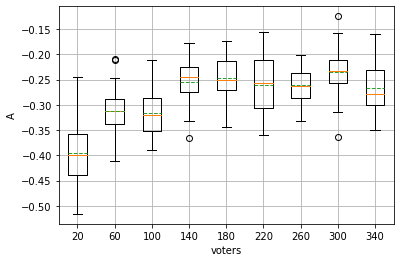

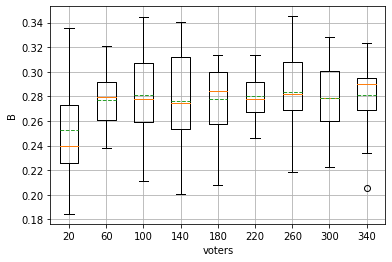

In [ ]:
Ass = np.array([[-0.38648325, -0.45631647, -0.38453262, -0.38076493, -0.37143735, -0.31586862, -0.3603716 , -0.24430095, -0.33788415, -0.50595541, -0.35413438, -0.4220361 , -0.42918673, -0.41772989, -0.31804088, -0.35925083, -0.2973327 , -0.48589411, -0.41013004, -0.44907463, -0.51590982, -0.43796077, -0.44031892, -0.41420761], [-0.41197194, -0.2829078 , -0.37705646, -0.40557726, -0.32669439, -0.21019248, -0.32744702, -0.29232865, -0.30841781, -0.2727791 , -0.21080909, -0.3736866 , -0.33578722, -0.29672689, -0.31135244, -0.34381603, -0.31280174, -0.2959091 , -0.35007534, -0.27621297, -0.31601537, -0.24776477, -0.3128006 , -0.28953371], [-0.34449216, -0.38842787, -0.38178074, -0.21902259, -0.3081208 , -0.28610462, -0.35278616, -0.34911712, -0.30881918, -0.35067509, -0.25432839, -0.35682369, -0.31755037, -0.34819085, -0.25862957, -0.27225557, -0.38199711, -0.32151576, -0.29570944, -0.28764043, -0.30137239, -0.38650853, -0.21189272, -0.32315006], [-0.2480762 , -0.17753791, -0.23805892, -0.26980931, -0.27945972, -0.36475772, -0.26207195, -0.22767173, -0.272759 , -0.22086043, -0.23787952, -0.22087952, -0.2201678 , -0.28800099, -0.19656306, -0.23825181, -0.20699882, -0.24193124, -0.30008869, -0.32029149, -0.33270443, -0.23534845, -0.25213344, -0.25100543], [-0.25521692, -0.27488775, -0.22915838, -0.17958441, -0.17316104, -0.25110072, -0.24256053, -0.24154928, -0.21389923, -0.20789644, -0.22773658, -0.29059188, -0.24884133, -0.263982 , -0.25489021, -0.26931309, -0.25861752, -0.20952401, -0.29140812, -0.21007786, -0.20458846, -0.34367777, -0.28289484, -0.28506034], [-0.23298969, -0.2921118 , -0.21150962, -0.28612561, -0.28309777, -0.36025138, -0.31269345, -0.29332242, -0.24677517, -0.33526822, -0.18573411, -0.23735474, -0.3344667 , -0.3291802 , -0.25810202, -0.31121203, -0.20794759, -0.15589942, -0.2399527 , -0.30495273, -0.18282661, -0.25448541, -0.2007261 , -0.21194432], [-0.30648644, -0.21049582, -0.28841996, -0.27684016, -0.26990581, -0.20193749, -0.22339187, -0.30248625, -0.26412831, -0.21840528, -0.28348995, -0.33105974, -0.2972239 , -0.25442368, -0.24147402, -0.28224329, -0.22198983, -0.28463303, -0.25951599, -0.24616122, -0.24402393, -0.30462804, -0.22009704, -0.24232689], [-0.20897913, -0.22454479, -0.23623709, -0.19652138, -0.1594185 , -0.26088489, -0.25414351, -0.1975798 , -0.15845236, -0.24408732, -0.24342417, -0.25570013, -0.21930712, -0.28633237, -0.22174301, -0.21153993, -0.28215612, -0.21329707, -0.24623357, -0.3142796 , -0.29460133, -0.12455753, -0.2303253 , -0.36421591], [-0.29873394, -0.1822908 , -0.29785559, -0.35016805, -0.3462064 , -0.27640391, -0.27813185, -0.23587221, -0.28189108, -0.30439017, -0.21869779, -0.26257784, -0.21557703, -0.27919736, -0.33676125, -0.30178384, -0.28329471, -0.24474994, -0.246534 , -0.15959601, -0.27824933, -0.21186703, -0.30387371, -0.20729978]])
Bss = np.array([[0.23775773, 0.2633752 , 0.23468096, 0.19093593, 0.24139168, 0.20352719, 0.22079458, 0.18447702, 0.22501639, 0.32696112, 0.23412092, 0.33543552, 0.26658543, 0.27607615, 0.27172401, 0.23857188, 0.20545003, 0.30334792, 0.26342845, 0.23818946, 0.33510322, 0.28659713, 0.26085986, 0.22611926], [0.27495771, 0.27017447, 0.26327255, 0.29068375, 0.27098883, 0.25170405, 0.29539685, 0.28537126, 0.28853358, 0.24021253, 0.28202296, 0.30538989, 0.31100033, 0.25354745, 0.30673679, 0.27624824, 0.26894571, 0.28414456, 0.29561585, 0.32077377, 0.25318066, 0.28233752, 0.2384632 , 0.24500588], [0.28325695, 0.31304592, 0.29840542, 0.26080424, 0.34418382, 0.2622897 , 0.3069177 , 0.32645559, 0.23521181, 0.27450264, 0.2327956 , 0.2553322 , 0.28785819, 0.26186047, 0.27204573, 0.24898956, 0.3112856 , 0.30619099, 0.26855569, 0.2556753 , 0.34024426, 0.28208044, 0.21155129, 0.30947009], [0.25415593, 0.20069343, 0.27606769, 0.24189737, 0.29365566, 0.31832907, 0.28153966, 0.26288725, 0.31329598, 0.20484166, 0.25913811, 0.25006197, 0.27390054, 0.31204651, 0.3167691 , 0.24142212, 0.27940902, 0.27044118, 0.31552128, 0.255725 , 0.34067602, 0.24211711, 0.29046307, 0.33344944], [0.29295825, 0.31335946, 0.2998386 , 0.24773718, 0.20764111, 0.28399744, 0.26602447, 0.30317023, 0.24542573, 0.27481235, 0.27792336, 0.29637496, 0.29528645, 0.30277058, 0.28409567, 0.3108231 , 0.26059099, 0.24176565, 0.30259984, 0.24671405, 0.29182523, 0.29999134, 0.24286335, 0.27418942], [0.31020275, 0.27381955, 0.29192747, 0.3033175 , 0.24581281, 0.26558811, 0.2779009 , 0.2759038 , 0.29607074, 0.31343156, 0.28296567, 0.25097604, 0.29012946, 0.27799189, 0.25312639, 0.27053879, 0.29256333, 0.26240012, 0.26747012, 0.25745645, 0.2776685 , 0.28553341, 0.3121437 , 0.29008888], [0.28661885, 0.31189042, 0.31089522, 0.28042203, 0.2811382 , 0.34516727, 0.28257205, 0.26716008, 0.29550959, 0.28024699, 0.26906546, 0.27815718, 0.21868073, 0.30691851, 0.3264915 , 0.33662338, 0.2220918 , 0.28851927, 0.24708321, 0.27615211, 0.29035653, 0.26514661, 0.22946865, 0.3176584 ], [0.29069558, 0.23954769, 0.22308906, 0.3224127 , 0.29191209, 0.27008913, 0.24033559, 0.29952408, 0.25148224, 0.29295811, 0.27998682, 0.27142574, 0.29129765, 0.2624883 , 0.24198048, 0.31464686, 0.32803096, 0.27329278, 0.27107889, 0.3213477 , 0.27801872, 0.22299671, 0.30359357, 0.31207494], [0.29421128, 0.28779842, 0.29320182, 0.28981958, 0.27152855, 0.30517448, 0.32350474, 0.2907184 , 0.29578884, 0.23434148, 0.24759899, 0.2057229 , 0.30473864, 0.27945067, 0.26682515, 0.29421239, 0.26920357, 0.26201888, 0.2610466 , 0.29574457, 0.3132899 , 0.29524413, 0.29028751, 0.28338027]])
Labels = ['20', '60', '100', '140', '180', '220', '260', '300', '340']

fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(Ass.tolist(), labels = Labels, meanline = True, showmeans = True)
ax.set_ylabel('A')
ax.set_xlabel('voters')
plt.show()
fig.set_size_inches(14, 8)
fig.savefig('A(V).png', dpi=600)


fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(Bss.tolist(), labels = Labels, meanline = True, showmeans = True)
ax.set_ylabel('B')
ax.set_xlabel('voters')
plt.show()
fig.set_size_inches(14, 8)
fig.savefig('B(V).png', dpi=600)

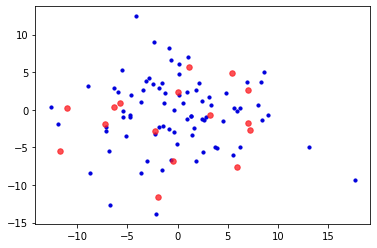

100%|██████████| 65536/65536 [00:00<00:00, 147096.11it/s]


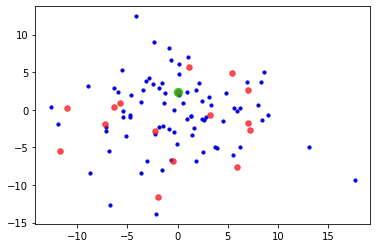

Score of Random is  0.45420002888291633
median Score of Random is  0.342401006870445
1 done Score is 0.45420002888291633


100%|██████████| 65536/65536 [00:00<00:00, 144537.93it/s]


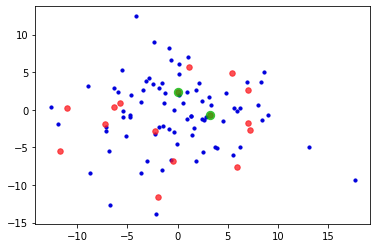

Score of Random is  0.5866431798337682
median Score of Random is  0.5280456873347407
2 done Score is 0.5866431798337682


100%|██████████| 65536/65536 [00:00<00:00, 79025.01it/s] 


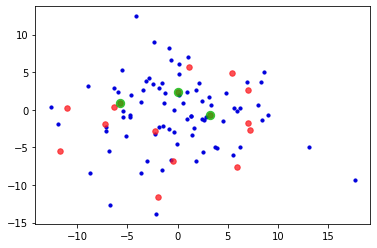

Score of Random is  0.6808325667708727
median Score of Random is  0.7109476140794652
3 done Score is 0.6808325667708727


100%|██████████| 65536/65536 [00:07<00:00, 8337.26it/s] 


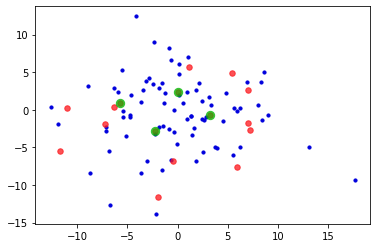

Score of Random is  0.7502921499453891
median Score of Random is  0.9314235294704234
4 done Score is 0.7502921499453891


100%|██████████| 65536/65536 [00:12<00:00, 5395.62it/s] 


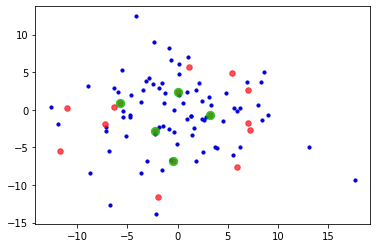

Score of Random is  0.7963949880367147
median Score of Random is  1.0
5 done Score is 0.7963949880367147


100%|██████████| 65536/65536 [00:15<00:00, 4335.39it/s] 


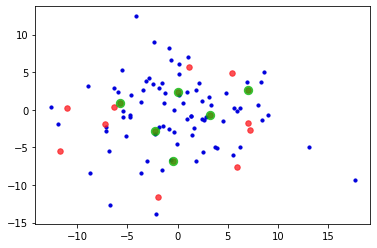

Score of Random is  0.8407276364874047
median Score of Random is  1.0
6 done Score is 0.8407276364874047


100%|██████████| 65536/65536 [00:27<00:00, 2369.85it/s]


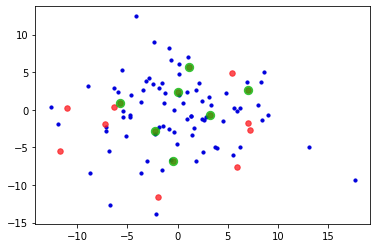

Score of Random is  0.8836796996809916
median Score of Random is  1.0
7 done Score is 0.8836796996809916


100%|██████████| 65536/65536 [00:34<00:00, 1910.84it/s]


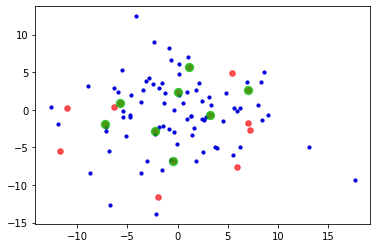

Score of Random is  0.913394639876112
median Score of Random is  1.0
8 done Score is 0.913394639876112


100%|██████████| 65536/65536 [00:33<00:00, 1928.86it/s]


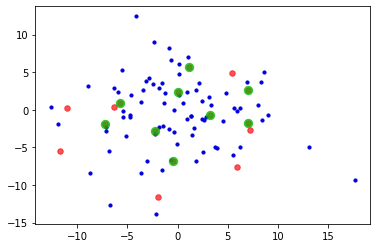

Score of Random is  0.9426610266463691
median Score of Random is  1.0
9 done Score is 0.9426610266463691


100%|██████████| 65536/65536 [00:23<00:00, 2747.66it/s]


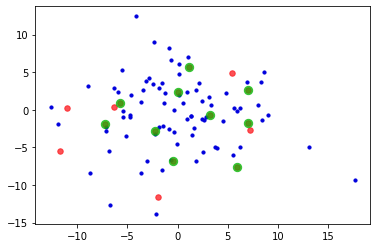

Score of Random is  0.9606447668778614
median Score of Random is  1.0
10 done Score is 0.9606447668778614


100%|██████████| 65536/65536 [00:13<00:00, 4766.70it/s]


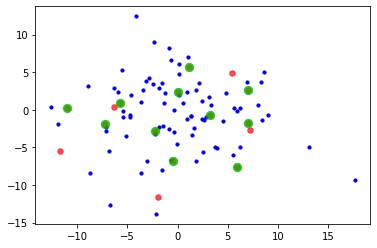

Score of Random is  0.9770181282303685
median Score of Random is  1.0
11 done Score is 0.9770181282303685


100%|██████████| 65536/65536 [00:06<00:00, 9986.80it/s]


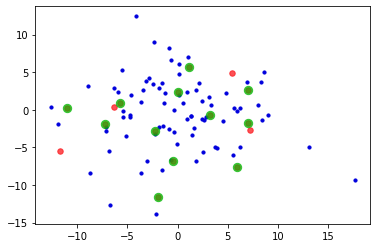

Score of Random is  0.9910706552419619
median Score of Random is  1.0
12 done Score is 0.9910706552419619


100%|██████████| 65536/65536 [00:03<00:00, 21364.32it/s]


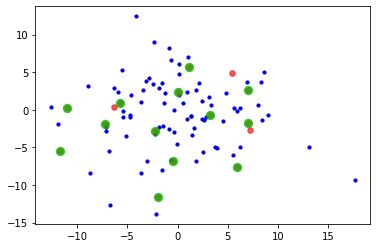

Score of Random is  0.9957757262821098
median Score of Random is  1.0
13 done Score is 0.9957757262821098


100%|██████████| 65536/65536 [00:02<00:00, 30396.93it/s]


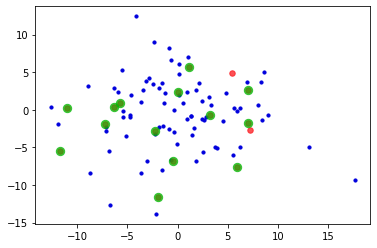

Score of Random is  0.9980105203767782
median Score of Random is  1.0
14 done Score is 0.9980105203767782


100%|██████████| 65536/65536 [00:00<00:00, 158855.63it/s]


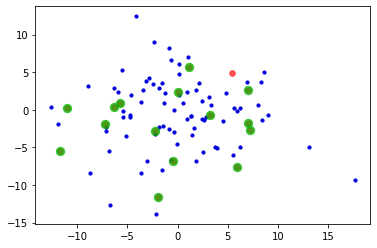

Score of Random is  1.0
median Score of Random is  1.0
15 done Score is 1.0


100%|██████████| 65536/65536 [00:00<00:00, 175759.77it/s]


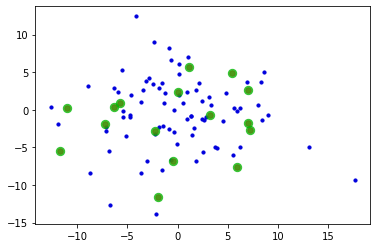

Score of Random is  1.0
median Score of Random is  1.0
16 done Score is 1.0


<ipython-input-2-c7e126148cea>:1098: RuntimeWarning: divide by zero encountered in power
  [a0, b0], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)


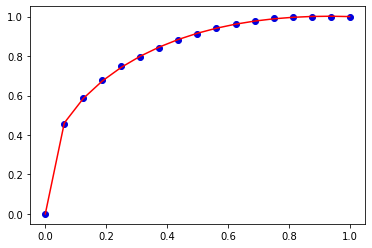

MaxScore(k)
-0.34758580531800465 0.30101051312649385


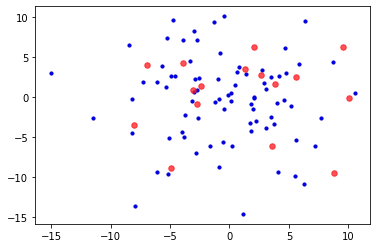

100%|██████████| 65536/65536 [00:00<00:00, 169052.85it/s]


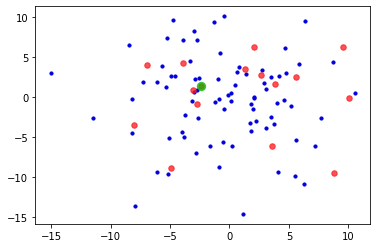

Score of Random is  0.4525914042682454
median Score of Random is  0.42152726995705064
1 done Score is 0.4525914042682454


100%|██████████| 65536/65536 [00:01<00:00, 45349.79it/s]


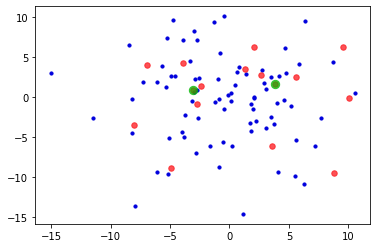

Score of Random is  0.5870302353355219
median Score of Random is  0.572784676403399
2 done Score is 0.5870302353355219


100%|██████████| 65536/65536 [00:00<00:00, 74599.18it/s] 


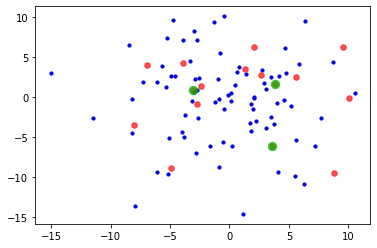

Score of Random is  0.6780880756874713
median Score of Random is  0.6773764742568449
3 done Score is 0.6780880756874713


100%|██████████| 65536/65536 [00:03<00:00, 20742.94it/s]


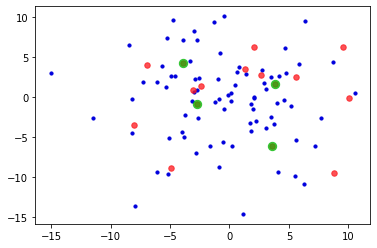

Score of Random is  0.7504471514793115
median Score of Random is  0.909393585700299
4 done Score is 0.7504471514793115


100%|██████████| 65536/65536 [00:10<00:00, 6410.66it/s] 


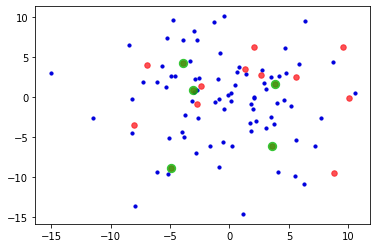

Score of Random is  0.7956638875644
median Score of Random is  0.9691851641743243
5 done Score is 0.7956638875644


100%|██████████| 65536/65536 [00:15<00:00, 4126.36it/s] 


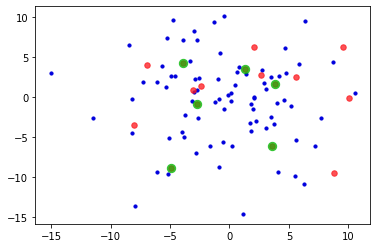

Score of Random is  0.8365421186979021
median Score of Random is  1.0
6 done Score is 0.8365421186979021


100%|██████████| 65536/65536 [00:25<00:00, 2521.43it/s]


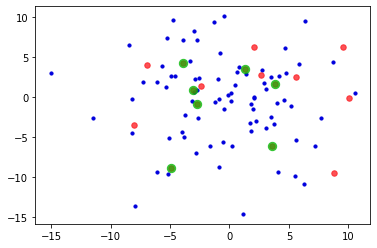

Score of Random is  0.8683456956810991
median Score of Random is  1.0
7 done Score is 0.8683456956810991


100%|██████████| 65536/65536 [00:36<00:00, 1794.23it/s]


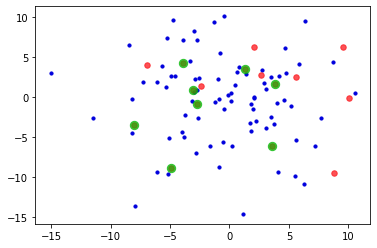

Score of Random is  0.8938385035050717
median Score of Random is  1.0
8 done Score is 0.8938385035050717


100%|██████████| 65536/65536 [00:37<00:00, 1759.02it/s]


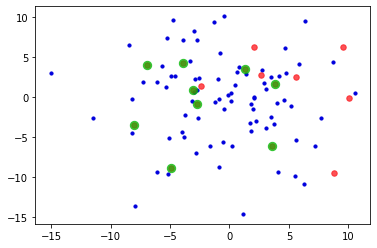

Score of Random is  0.9145473357361968
median Score of Random is  1.0
9 done Score is 0.9145473357361968


100%|██████████| 65536/65536 [00:24<00:00, 2723.23it/s]


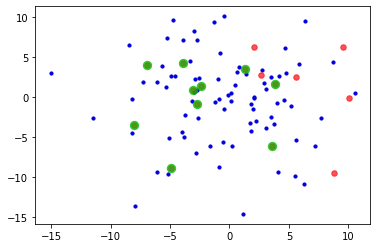

Score of Random is  0.9317665644141586
median Score of Random is  1.0
10 done Score is 0.9317665644141586


100%|██████████| 65536/65536 [00:14<00:00, 4527.48it/s]


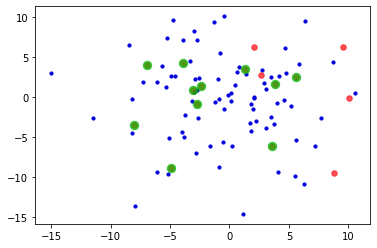

Score of Random is  0.948541179713757
median Score of Random is  1.0
11 done Score is 0.948541179713757


100%|██████████| 65536/65536 [00:06<00:00, 10392.71it/s]


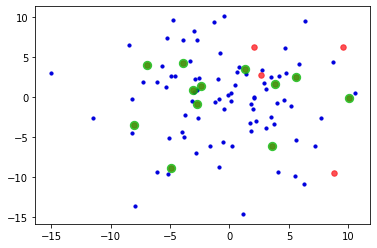

Score of Random is  0.9636718144554276
median Score of Random is  1.0
12 done Score is 0.9636718144554276


100%|██████████| 65536/65536 [00:02<00:00, 25522.92it/s]


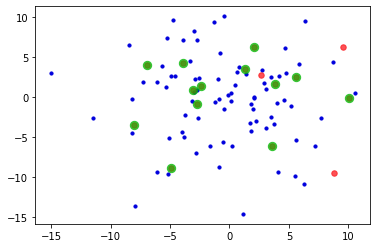

Score of Random is  0.9759130102638036
median Score of Random is  1.0
13 done Score is 0.9759130102638036


100%|██████████| 65536/65536 [00:00<00:00, 75934.28it/s]


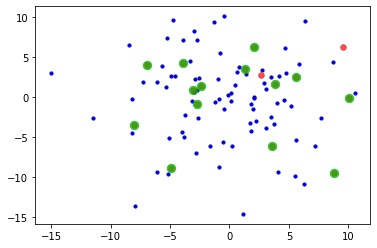

Score of Random is  0.9848928117775845
median Score of Random is  1.0
14 done Score is 0.9848928117775845


100%|██████████| 65536/65536 [00:00<00:00, 155929.90it/s]


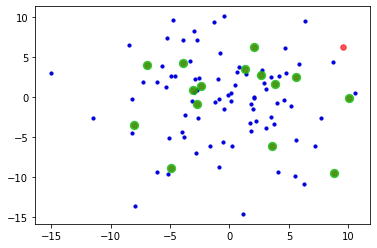

Score of Random is  0.9929118411682282
median Score of Random is  1.0
15 done Score is 0.9929118411682282


100%|██████████| 65536/65536 [00:01<00:00, 51670.41it/s]


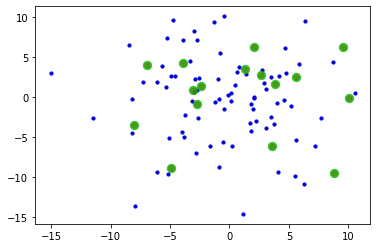

Score of Random is  1.0
median Score of Random is  1.0
16 done Score is 1.0


<ipython-input-2-c7e126148cea>:1098: RuntimeWarning: divide by zero encountered in power
  [a0, b0], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)


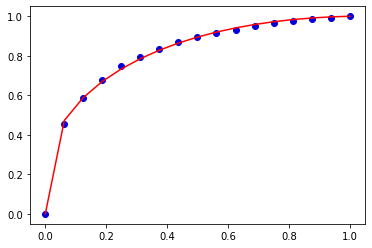

MaxScore(k)
-0.24998238359200017 0.2857879781017445


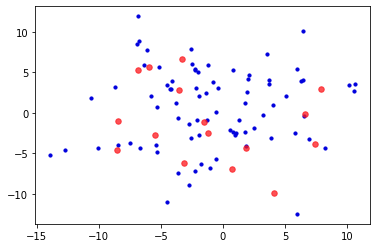

100%|██████████| 65536/65536 [00:00<00:00, 162895.92it/s]


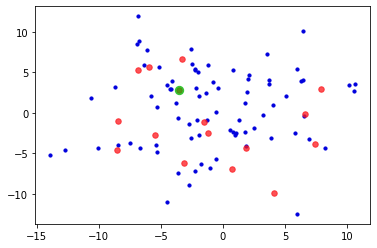

Score of Random is  0.4515731936722315
median Score of Random is  0.33077092448156686
1 done Score is 0.4515731936722315


100%|██████████| 65536/65536 [00:01<00:00, 48634.99it/s]


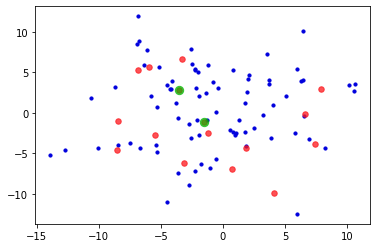

Score of Random is  0.5690100091648428
median Score of Random is  0.5401321288188886
2 done Score is 0.5690100091648428


100%|██████████| 65536/65536 [00:02<00:00, 23636.98it/s]


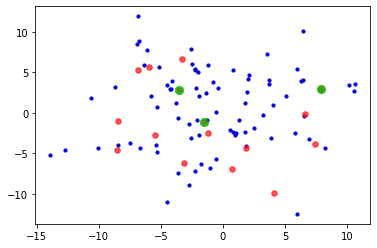

Score of Random is  0.6573628271335761
median Score of Random is  0.6675500196961333
3 done Score is 0.6573628271335761


100%|██████████| 65536/65536 [00:05<00:00, 12785.82it/s]


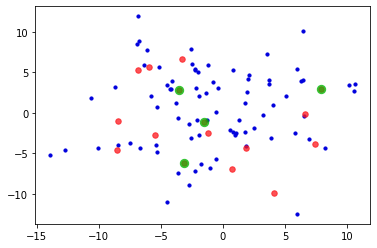

Score of Random is  0.7242349518694657
median Score of Random is  0.8163016686630182
4 done Score is 0.7242349518694657


100%|██████████| 65536/65536 [00:10<00:00, 6111.88it/s] 


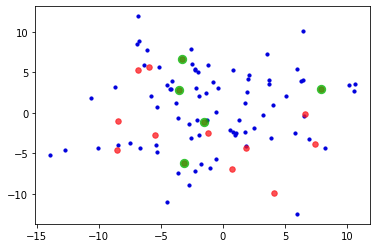

Score of Random is  0.7810955694220755
median Score of Random is  1.0
5 done Score is 0.7810955694220755


100%|██████████| 65536/65536 [00:19<00:00, 3394.22it/s]


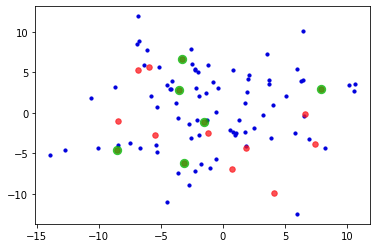

Score of Random is  0.8316247819619271
median Score of Random is  1.0
6 done Score is 0.8316247819619271


100%|██████████| 65536/65536 [00:30<00:00, 2118.12it/s]


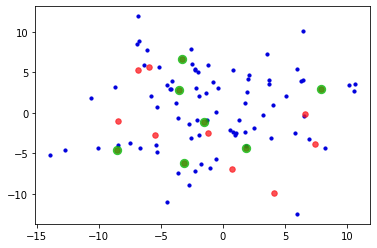

Score of Random is  0.8756930296677279
median Score of Random is  1.0
7 done Score is 0.8756930296677279


100%|██████████| 65536/65536 [00:33<00:00, 1979.23it/s]


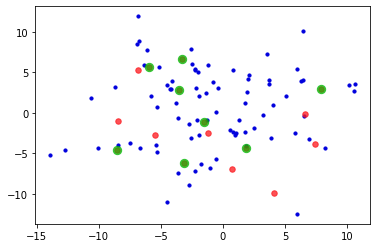

Score of Random is  0.9063187751593869
median Score of Random is  1.0
8 done Score is 0.9063187751593869


100%|██████████| 65536/65536 [00:30<00:00, 2150.30it/s]


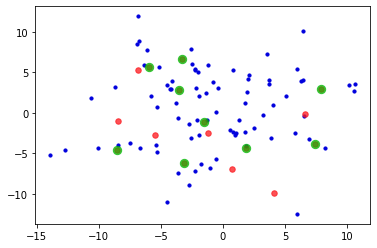

Score of Random is  0.9342722865153075
median Score of Random is  1.0
9 done Score is 0.9342722865153075


100%|██████████| 65536/65536 [00:22<00:00, 2956.53it/s]


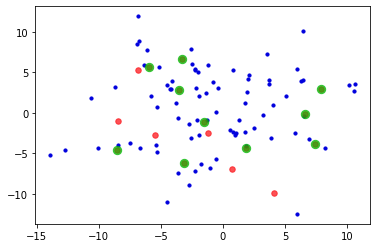

Score of Random is  0.9536311586126164
median Score of Random is  1.0
10 done Score is 0.9536311586126164


100%|██████████| 65536/65536 [00:16<00:00, 3994.04it/s]


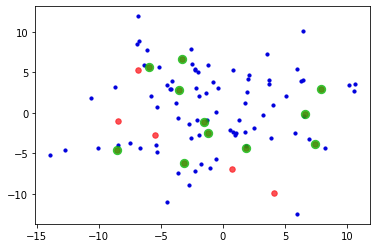

Score of Random is  0.9678993207722751
median Score of Random is  1.0
11 done Score is 0.9678993207722751


100%|██████████| 65536/65536 [00:04<00:00, 14502.16it/s]


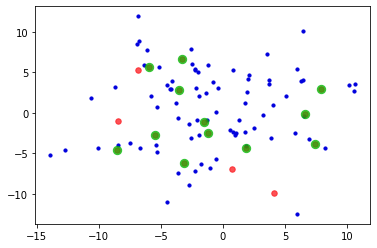

Score of Random is  0.9775707178021893
median Score of Random is  1.0
12 done Score is 0.9775707178021893


100%|██████████| 65536/65536 [00:01<00:00, 33097.29it/s]


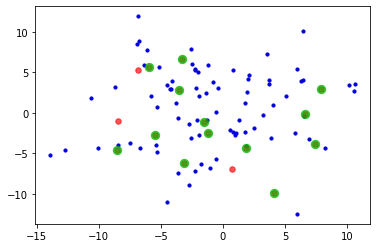

Score of Random is  0.9855646690384517
median Score of Random is  1.0
13 done Score is 0.9855646690384517


100%|██████████| 65536/65536 [00:01<00:00, 43648.85it/s]


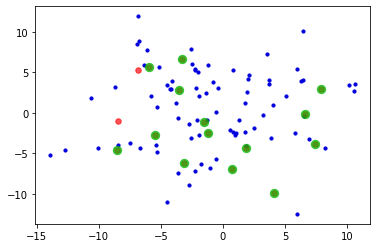

Score of Random is  0.9920769575494784
median Score of Random is  1.0
14 done Score is 0.9920769575494784


100%|██████████| 65536/65536 [00:00<00:00, 154756.26it/s]


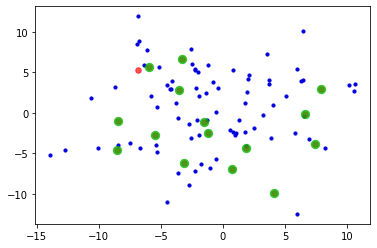

Score of Random is  0.9971188713565375
median Score of Random is  1.0
15 done Score is 0.9971188713565375


100%|██████████| 65536/65536 [00:00<00:00, 165841.86it/s]


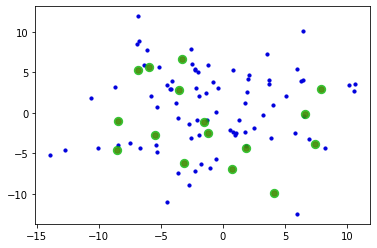

Score of Random is  1.0
median Score of Random is  1.0
16 done Score is 1.0


<ipython-input-2-c7e126148cea>:1098: RuntimeWarning: divide by zero encountered in power
  [a0, b0], res = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y)


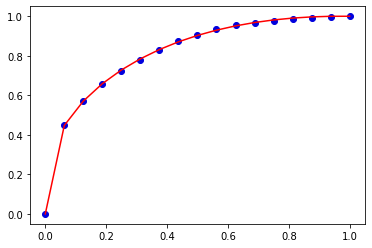

MaxScore(k)
-0.3261444198077272 0.3103244146448281


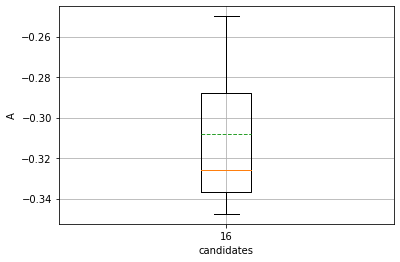

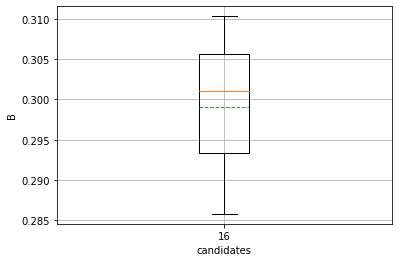

In [4]:
q = 3
M = 16
end = 2
sss = np.zeros((q, M))

A = np.zeros((end//2, q))
B = np.zeros((end//2, q))
Labels = []
for m in range(0, end, 2):
  sss = np.zeros((q, M + m))
  Labels.append(str(M+m))
  for i in range(q):
    sss[i], A[m//2][i], B[m//2][i] = testBF(MMM = M+m, Vam = 80, dist1 = 'normal', dist2 = 'normal', b1 = 5, b2 = 5)


fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(A.tolist(), labels = Labels, meanline = True, showmeans = True)
ax.set_ylabel('A')
ax.set_xlabel('candidates')
plt.show()
fig.set_size_inches(14, 8)
fig.savefig('A(C).png', dpi=600)


fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(B.tolist(), labels = Labels, meanline = True, showmeans = True)
ax.set_ylabel('B')
ax.set_xlabel('candidates')
plt.show()
fig.set_size_inches(14, 8)
fig.savefig('B(C).png', dpi=600)

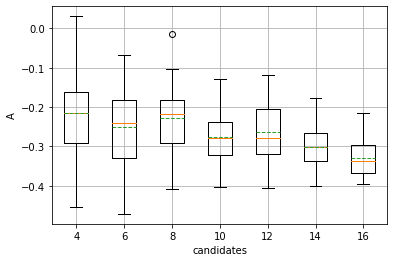

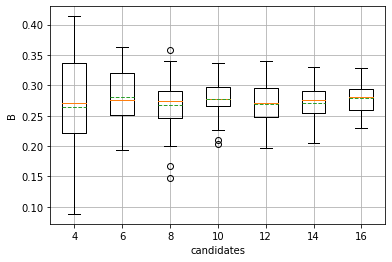

In [19]:
A = np.array([[-0.20928375, -0.16054676, -0.35474559, -0.01362281, -0.20413112, -0.1668694 , -0.23280286, -0.22168761, 0.03073774, -0.16351768, -0.29925443, -0.12070373, -0.45407149, -0.05987443, -0.33554965, -0.1677179 , -0.23787658, -0.20274664, -0.28757691, -0.40568549, -0.25651243, -0.43609957, -0.2539855 , 0.00509599, -0.12990125, -0.07650272, -0.33835554, -0.23092905, -0.18161306, -0.29331402], [-0.35095072, -0.37879879, -0.47176375, -0.33537398, -0.22236259, -0.21005334, -0.22570695, -0.4232521 , -0.19084645, -0.20765377, -0.17802432, -0.2588226 , -0.07709848, -0.2577371 , -0.37047487, -0.28576102, -0.26039979, -0.10912747, -0.22571247, -0.16386434, -0.17372419, -0.34544288, -0.1803013 , -0.06768893, -0.30740404, -0.18425373, -0.33711389, -0.14532155, -0.28374363, -0.3027644 ], [-0.21604794, -0.12531519, -0.36343942, -0.20457184, -0.12013823, -0.13944421, -0.29478427, -0.25873413, -0.18258761, -0.29631991, -0.26854964, -0.21860042, -0.27808654, -0.19388417, -0.20256846, -0.17713871, -0.10347331, -0.33856702, -0.21915522, -0.3654017 , -0.01533513, -0.1486414 , -0.25770059, -0.3466664 , -0.25668823, -0.19465745, -0.19038514, -0.30197103, -0.18180418, -0.40803293], [-0.33608981, -0.20857961, -0.4026888 , -0.14656755, -0.12940178, -0.26507323, -0.23369186, -0.27496591, -0.30177565, -0.22430111, -0.30576512, -0.25679611, -0.3289119 , -0.22532576, -0.32981937, -0.27130996, -0.26506896, -0.29380809, -0.38300636, -0.36122453, -0.32587728, -0.28970694, -0.25271174, -0.30331055, -0.28324306, -0.35304045, -0.17381809, -0.2582968 , -0.30126122, -0.17666459], [-0.1897737 , -0.34032141, -0.13690229, -0.21719896, -0.22900656, -0.32056465, -0.1197086 , -0.28147813, -0.28552124, -0.18582809, -0.20353646, -0.3638551 , -0.13409713, -0.27796021, -0.28349812, -0.28880193, -0.32012173, -0.27247039, -0.15715878, -0.22371315, -0.27123778, -0.33491021, -0.35346799, -0.36953213, -0.30293507, -0.4050763 , -0.31998064, -0.21303471, -0.32524364, -0.19785044], [-0.37178836, -0.26430305, -0.40041211, -0.28424746, -0.30884811, -0.33293572, -0.30018072, -0.32722635, -0.29335072, -0.37063318, -0.32696231, -0.29236085, -0.2541945 , -0.3400111 , -0.34695693, -0.22416208, -0.30478116, -0.21824688, -0.3836583 , -0.27466087, -0.23754417, -0.29915778, -0.2449841 , -0.17595335, -0.27746597, -0.22639354, -0.32865164, -0.35611445, -0.30999559, -0.38932924], [-0.28348524, -0.37208858, -0.36737009, -0.24791515, -0.30724903, -0.39526647, -0.35453801, -0.35821086, -0.33430643, -0.30090407, -0.21525298, -0.36514569, -0.38132042, -0.28890014, -0.37636366, -0.28989064, -0.3677187, -0.33691932, -0.27160053, -0.33708428, -0.39342061, -0.35998931, -0.36656227,  -0.29641553, -0.29620643, -0.33225966, -0.38043739, -0.34758581, -0.24998238, -0.32614442]])
B = np.array([[0.2382093 , 0.21928887, 0.28618519, 0.27795165, 0.22100148, 0.23529374, 0.34673338, 0.26363608, 0.088933 , 0.29021946, 0.31448857, 0.24166369, 0.38450883, 0.1660913 , 0.24764145, 0.18774612, 0.29605203, 0.34156798, 0.22558191, 0.33698086, 0.36450115, 0.3438657 , 0.22227224, 0.15551021, 0.14008003, 0.08828825, 0.33252239, 0.34736269, 0.29546058, 0.41362535], [0.34294689, 0.34978124, 0.32365603, 0.30694851, 0.31891576, 0.28840976, 0.33845246, 0.34531234, 0.19398881, 0.26987495, 0.20979151, 0.2727667 , 0.23124449, 0.25929745, 0.32109451, 0.25499962, 0.22217233, 0.283012 , 0.27108542, 0.20388252, 0.27123065, 0.32078579, 0.22608553, 0.20564721, 0.27807831, 0.24931002, 0.35484305, 0.29072677, 0.36330857, 0.25595086], [0.27125322, 0.28400818, 0.23894175, 0.28767797, 0.25581487, 0.19975243, 0.30278118, 0.24236766, 0.32078924, 0.27696069, 0.25757532, 0.22776956, 0.29839912, 0.23993527, 0.256898 , 0.25841546, 0.22894293, 0.25456839, 0.27236043, 0.28902021, 0.16719287, 0.14689185, 0.28709292, 0.33958309, 0.2766804 , 0.28568137, 0.29522443, 0.3586935 , 0.29034093, 0.30034377], [0.26610133, 0.30651143, 0.33291692, 0.20276809, 0.2092868 , 0.27982093, 0.27015271, 0.29561531, 0.2841078 , 0.31275887, 0.29713466, 0.26583552, 0.2642545 , 0.27589855, 0.29427197, 0.27380292, 0.33749288, 0.3109859 , 0.26704147, 0.28252451, 0.29652314, 0.27598039, 0.26728791, 0.31367346, 0.24078959, 0.30121256, 0.24278195, 0.26188088, 0.22708357, 0.28010281], [0.29807644, 0.27397898, 0.19654299, 0.30120842, 0.23813958, 0.25921663, 0.27130334, 0.310635 , 0.20904153, 0.2935283 , 0.28709732, 0.27313024, 0.25605992, 0.29533732, 0.26430757, 0.28949732, 0.27026466, 0.28136582, 0.26468475, 0.23432334, 0.34054297, 0.22342116, 0.31788564, 0.24412875, 0.31044444, 0.31937996, 0.23574908, 0.20588968, 0.26124671, 0.27062756], [0.27916635, 0.26526345, 0.2792002 , 0.24974695, 0.23003298, 0.24746269, 0.29117131, 0.28504574, 0.26547874, 0.31319043, 0.29213692, 0.26571883, 0.31620175, 0.29832979, 0.28580012, 0.29883691, 0.26533428, 0.32968761, 0.27402945, 0.20855124, 0.20480275, 0.30320004, 0.26995218, 0.21692657, 0.27767122, 0.23459354, 0.22820017, 0.26505095, 0.28653676, 0.29082566], [0.27339877, 0.27982822, 0.2930275 , 0.2379913 , 0.25661932, 0.28694389, 0.27406993, 0.28084014, 0.25833947, 0.24850389, 0.31739443, 0.2791008 , 0.28383125, 0.25115372, 0.29121283, 0.25744072, 0.27473433, 0.31127791, 0.2812999 , 0.2302866 , 0.30008237, 0.29461631, 0.3121976 , 0.24448193, 0.26404739, 0.26141201, 0.32871453, 0.30101051, 0.28578798, 0.31032441]])
Labels = ['4', '6', '8', '10', '12', '14', '16']

fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(A.tolist(), labels = Labels, meanline = True, showmeans = True)
ax.set_ylabel('A')
ax.set_xlabel('candidates')
plt.show()
fig.set_size_inches(14, 8)
fig.savefig('A(C).png', dpi=600)


fig, ax = plt.subplots()
ax.grid(True)
ax.boxplot(B.tolist(), labels = Labels, meanline = True, showmeans = True)
ax.set_ylabel('B')
ax.set_xlabel('candidates')
plt.show()
fig.set_size_inches(14, 8)
fig.savefig('B(C).png', dpi=600)

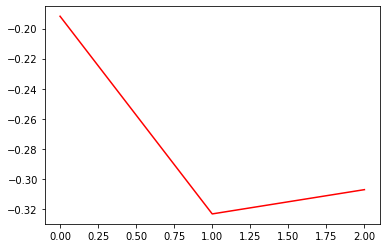

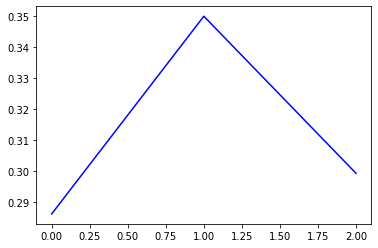

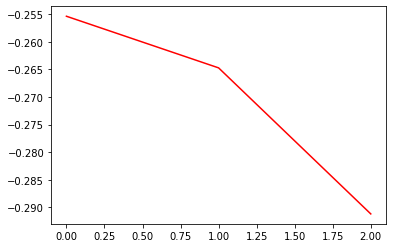

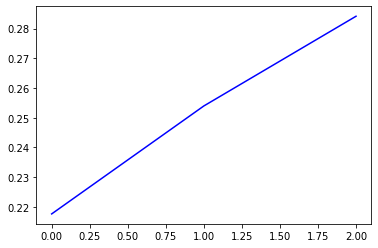

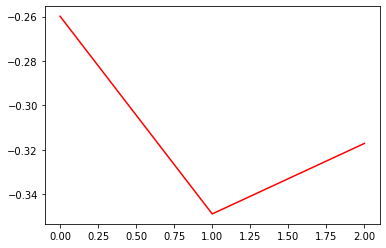

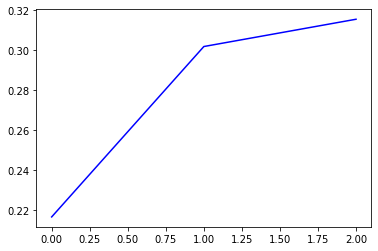

In [ ]:
As = [[], [], [], []]
Bs = [[], [], [], []]
for i in range(3):
  As[i] = [A0[i], A1[i], A2[i]]
  Bs[i] = [B0[i], B1[i], B2[i]]
  plt.plot(Q, As[i], 'r')
  plt.show()
  plt.plot(Q, Bs[i], 'b')
  plt.show()


In [ ]:


# open the file in the write mode
f = open('sss.csv', 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerows(np.transpose(sss))

# close the file
f.close()

In [ ]:
cunt = np.arange(13)
cunt = np.insert(cunt, 0, 13)
cunt

array([13,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

<ipython-input-39-7934570d3c56>:11: RuntimeWarning: divide by zero encountered in power
  [a0, b0], res4 = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y00)
<ipython-input-39-7934570d3c56>:12: RuntimeWarning: divide by zero encountered in power
  [a1, b1], res4 = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y01)
<ipython-input-39-7934570d3c56>:13: RuntimeWarning: divide by zero encountered in power
  [a2, b2], res4 = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y02)
<ipython-input-39-7934570d3c56>:14: RuntimeWarning: divide by zero encountered in power
  [a3, b3], res4 = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y03)
<ipython-input-39-7934570d3c56>:15: RuntimeWarning: divide by zero encountered in power
  [a4, b4], res4 = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y04)


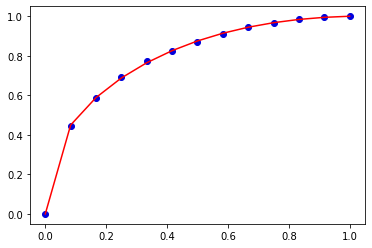

-0.3095744370387078 0.3473371222321847


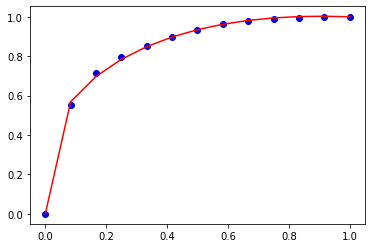

-0.3098457877078789 0.25277095503012725


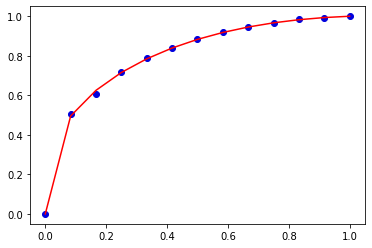

-0.2474742710304543 0.3032961540261716


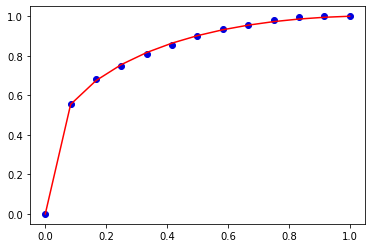

-0.21213999092710614 0.255123892387813


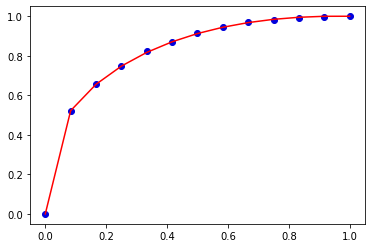

-0.31011388411410673 0.28724818982866507


In [ ]:
#cunt = np.arange(1, 13)
cunt = np.arange(13)
x = cunt/12

#y = sss[1]
y00 = np.insert(sss[0], 0, 0)
y01 = np.insert(sss[1], 0, 0)
y02 = np.insert(sss[2], 0, 0)
y03 = np.insert(sss[3], 0, 0)
y04 = np.insert(sss[4], 0, 0)
[a0, b0], res4 = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y00)
[a1, b1], res4 = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y01)
[a2, b2], res4 = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y02)
[a3, b3], res4 = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y03)
[a4, b4], res4 = curve_fit(lambda x1,a,b: np.power(x1, a*x1 + b),  x,  y04)

y0 = np.power(x, -0.3*x + 0.3)
y1 = np.power(x, a1*x + b1)
y2 = np.power(x, a2*x + b2)
y3 = np.power(x, a3*x + b3)
y4 = np.power(x, a4*x + b4)


plt.scatter(x, y00, c = '#0101dd')
plt.plot(x, y0, 'r')
plt.show()
print(a0, b0)

plt.scatter(x, y01, c = '#0101dd')
plt.plot(x, y1, 'r')
plt.show()
print(a1, b1)

plt.scatter(x, y02, c = '#0101dd')
plt.plot(x, y2, 'r')
plt.show()
print(a2, b2)

plt.scatter(x, y03, c = '#0101dd')
plt.plot(x, y3, 'r')
plt.show()
print(a3, b3)

plt.scatter(x, y04, c = '#0101dd')
plt.plot(x, y4, 'r')
plt.show()
print(a4, b4)

In [ ]:
ToBin(1023, 20)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

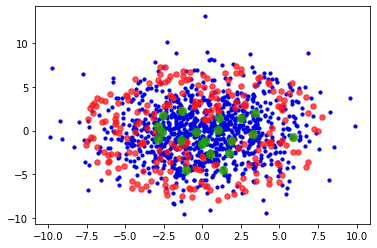

Score of SNTV rule is  0.5638064998851398
median Score of SNTV rule is  0.4810762879534183


In [ ]:
CP = Plurality_Score(VoteLists, Vamount, Camount, ComAmount, C, V, d1)
CS = STV(VoteLists, Vamount, Camount, ComAmount, C, V, d1)

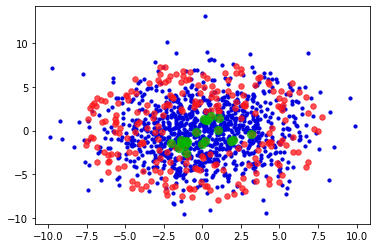

Score of k-Approval rule is  0.42215015275031037
median Score of k-Approval rule is  0.24890870333607484


In [ ]:
CA = Approval_Score(VoteLists, Vamount, Camount, ComAmount, C, V, d1)

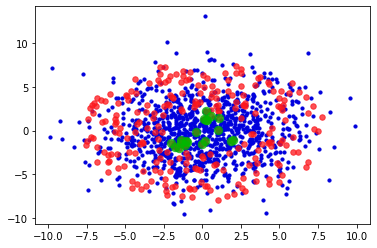

Score of k-Borda rule is  0.40044807632039287
median Score of k-Borda rule is  0.2260873444153933


In [ ]:
CB = Borda_Score(VoteLists, Vamount, Camount, ComAmount, C, V, d1)

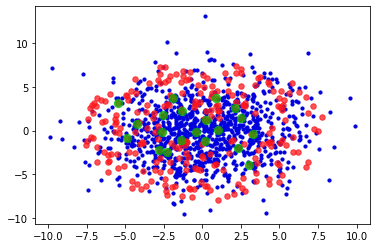

Score of STV rule is  0.5604827440596273
median Score of STV rule is  0.4704165865094184


  0%|          | 3/5000 [00:00<03:51, 21.60it/s]

0.42034543721463113
0.43489610370692505


  0%|          | 9/5000 [00:00<04:03, 20.49it/s]

0.44970861254745687


  2%|▏         | 96/5000 [00:04<03:50, 21.31it/s]

0.45343717475556683


  2%|▏         | 123/5000 [00:05<03:47, 21.48it/s]

0.4732514194872624


  6%|▌         | 303/5000 [00:14<03:41, 21.25it/s]

0.47513717154730806


 11%|█         | 528/5000 [00:24<03:29, 21.30it/s]

0.4809848369691841


 15%|█▌        | 774/5000 [00:36<03:19, 21.23it/s]

0.4851796065484958


 65%|██████▌   | 3252/5000 [02:30<01:21, 21.36it/s]

0.49386169706776983


100%|██████████| 5000/5000 [03:51<00:00, 21.58it/s]


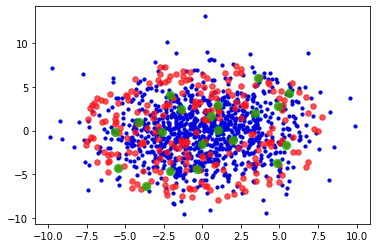

Score of Random is  0.49386169706776983
median Score of Random is  0.4278581063923276


  0%|          | 3/5000 [00:00<03:50, 21.69it/s]

0.2853634697463745
0.3342615047391744
0.33469769300017305


  0%|          | 15/5000 [00:00<03:56, 21.08it/s]

0.36529902641813844


  1%|▏         | 66/5000 [00:03<03:52, 21.25it/s]

0.3824863555213333


  2%|▏         | 75/5000 [00:03<03:52, 21.19it/s]

0.3830809130756994


  2%|▏         | 81/5000 [00:03<03:51, 21.23it/s]

0.41081579181777717


 31%|███       | 1531/5000 [01:14<02:41, 21.42it/s]

0.42184219531802025


 43%|████▎     | 2133/5000 [01:42<02:19, 20.57it/s]

0.4267942167945576


100%|██████████| 5000/5000 [03:58<00:00, 20.94it/s]


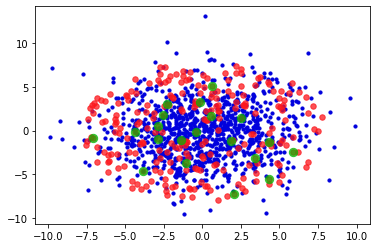

Score of Random is  0.5051119671189644
median Score of Random is  0.4267942167945576


In [ ]:
listCan = np.arange(Camount)
RR = randCom(listCan, Vamount, Camount, ComAmount, C, V, d1)
RR = randComMed(listCan, Vamount, Camount, ComAmount, C, V, d1)


Removed1 45
Removed2 68
Removed2.1 23
Mean Dist is 0.4455142141038181
Removed3 35


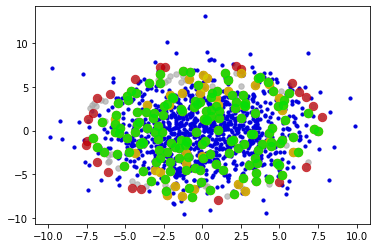

In [ ]:
OptC = Opt(VoteLists, Vamount, Camount, ComAmount, C, V, d1)

In [ ]:
print(CP)

[[-0.3934253   0.9958697   2.53221388 -1.31173063  0.14641109 -2.88044918
   3.29987815 -2.61427636  3.40992572  1.8409837  -1.41628092  1.72358472
   0.48198963  1.05120018  1.34618393 -2.57367522 -0.03659    -2.91306843
   5.89073266 -1.03841379]
 [-0.11614292  0.07108287  1.39954627  2.22543125 -1.23962823  0.56947434
  -0.33609633 -0.21181809  1.99246388 -1.24931788 -1.07713641 -2.60500673
  -2.70507776  1.4966241  -4.50312901  1.82839867 -1.50907362 -0.99607167
  -0.76604069 -4.48042346]]
